# Notebook to experiment with topic model

# Imports

In [1]:
%%bash
pip install seaborn
pip install pdfminer.six
pip install spacy
# python -m spacy download en

In [33]:
from utils import load_pdfs, read_pdf, topic_model
import re
import os
import string
import nltk
import pandas as pd

# Part 1 Load PDFs from folder 'papers'

In [7]:
def get_file_names(folder='papers'):
    """
    
    :param folder: string, name of folder where the papers are contained
    :return: string foldername, list filenames
    """
    if not os.path.exists(folder):
        os.makedirs(folder)
    file_names = os.listdir(folder)
    return folder, file_names


foldername, filenames = get_file_names('papers')

filenames


['.DS_Store',
 '2018_ICIS_Laing_Kuehl_Comfort-as-a-Service.pdf',
 '2018_ICIS_Hirt_Kuehl_Cognition-in-the-era-of-Smart-Service-Systems.pdf',
 '2018_ICIS_Hirt-Kuehl_Cognition-in-the-era-of-Smart-Service-Systems-camera-ready.pdf']

# Part 2 Retrieve the text from the PDF files

We use pdf miner to retrieve the text from the filenames in our 'papers' folder

In [8]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import XMLConverter, TextConverter
from pdfminer.layout import LAParams
import io

# TODO check if this works for multiple papers too
# TODO e.g. is it possible to create a list of tokens for each? 
# TODO what is the best way to do this?
# TODO is this already sth that should be returned in the end?


def pdfparser(filename):
    """
    
    :param data: filename (string)
    :return: text data (string), the complete text in the document(s)
    """
    fp = open(filename, 'rb')
    rsrcmgr = PDFResourceManager()
    retstr = io.StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    # Create a PDF interpreter object.
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    # Process each page contained in the document.

    for page in PDFPage.get_pages(fp):
        interpreter.process_page(page)
        data = retstr.getvalue()
    return data


In [14]:
text = []

for each in range(len(filenames)):
    if not filenames[each].startswith('.'):
        text.append(pdfparser(foldername+'/'+filenames[each]))
    
len(text)

3

In [15]:
len(text[0])

65760

In [22]:
# each = pdfparser(foldername+'/'+filenames[0])  # example, just for the first paper

# TODO cleansing operations directly on raw each
for each in text:
    each= each.replace("\n"," ")
    each = re.sub(r'\d+', '', each)
    each = each.translate(str.maketrans("","", string.punctuation))
    each = each.strip()
    # each = each.strip("\r\n")
    each = re.sub(r'\b\w{1,3}\b', '', each)
    # each = [tok for tok in each if tok not in STOPLIST and tok not in punctuations]
    # each = ' '.join(each)

In [23]:
text[0:600]

[" \n \n\nComfort-as-a-Service: User-Oriented Thermal Comfort Artifact \n \n\nComfort-as-a-Service: Designing a User-\n\nOriented Thermal Comfort Artifact for Office \n\nBuildings \n\nCompleted Research Paper \n\n \n\nSvenja Laing \n\nNiklas Kühl \n\nIBM Deutschland GmbH \n\nIBM-Allee 1, 71139 Ehningen  \n\nKarlsruhe Institute of Technology \n\nKaiserstr 89, 76133 Karlsruhe \n\nGermany \n\nsvenja.laing@ibm.com \n\n \n\n \n\nGermany \n\nkuehl@kit.edu \n\n \n\nAbstract \n\nMost  people  spend  up  to  90  %  of  their  time  indoors.  However,  literature  in  the  field  of \nfacility  management  and  related  disciplines  mostly  focus  on  energy  and  cost  saving \naspects of buildings. Especially in the area of commercial buildings, only few articles take \na user-centric perspective and none of them considers the subjectivity of thermal comfort. \nThis  work  addresses  this  research  gap  and  aims  to  optimize  individual  environmental \ncomfort  in  open  office  environmen

# Part 3 Quick data exploration: check of top x words with nltk freqdist

In [24]:
all_tokens = []
for each in range(len(text)):
    all_tokens.append(topic_model.prepare_text_for_lda(text[each]))

In [25]:
len(all_tokens)

3

In [28]:
# Calculate frequency distribution
dict_object = []
for each in all_tokens:
    fdist = nltk.FreqDist(each)
    # Output top 20 words
    word_list = []
    frequency_list = []
    for word, frequency in fdist.most_common(10):
        word_list.append(word)
        frequency_list.append(frequency)
    frequency_dict = dict(zip(word_list, frequency_list))
    dict_object.append(frequency_dict)
        # print(u'{};{}'.format(word, frequency))
    # print('\n')



In [37]:
def print_dict_object(dct, paper_title):
    print("Top 10 words for the paper {}:".format(paper_title))
    for item, amount in dct.items():
        print("{} : ({})".format(item, amount))

In [38]:
print_dict_object(dict_object[0], filenames[0])

Top 10 words for the paper .DS_Store:
comfort : (150)
thermal : (125)
building : (77)
model : (76)
design : (58)
cycle : (56)
feedback : (55)
research : (43)
office : (42)
result : (42)


In [39]:
def plot_dict_object(dct, paper_title):
    plot_df = pd.DataFrame.from_dict(dct, orient='index')
    plot_df.columns = ['nr']
    plot_df.nr = plot_df.nr.astype(int)
    return plot_df.sort_values("nr", ascending=True).plot.barh()

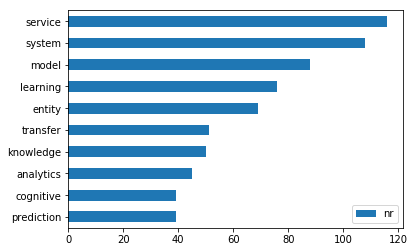

In [40]:
plot_dict_object(dict_object[1], filenames[1])

In [41]:
def mutual_words(listA, listB):
    return list(set(listA) & set(listB))

In [44]:
mutual_words(list(dict_object[1].keys()), list(dict_object[2].keys()))

['service',
 'learning',
 'system',
 'prediction',
 'transfer',
 'knowledge',
 'entity',
 'cognitive',
 'analytics',
 'model']

In [43]:
# Wordclouds
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

# Part 4 Preprocessing: remove punctuation, newline chars, stopwords etc

In [49]:
import spacy
nlp = spacy.load('en')

# text is a string of all the separate tokens
print("The paper contains " + str(len(text)) + " tokens in total")
print("Here are the tokens at position 400-420: \n\n '" + str(text[400:420]) + " ' \n")

# create spacy tokens
tokens = nlp(text[0])
print("After conversion to " + str(type(tokens)) + " the paper contains " + str(len(tokens)) + " tokens")
print("Here are the tokens at position 400-420:  \n\n'" + str(tokens[400:420]) + "'")


The paper contains 3 tokens in total
Here are the tokens at position 400-420: 

 '[] ' 

After conversion to <class 'spacy.tokens.doc.Doc'> the paper contains 14746 tokens
Here are the tokens at position 400-420:  

' or  what  to  wear,  to  feel 
comfortable and work productively. Therefore'


## 4a) Remove stopwords and punctuations

In [50]:
from nltk.corpus import stopwords
STOPLIST = set(stopwords.words('english'))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]
punctuations = string.punctuation


def clean_up(tokens):
    clean_tokens = []
    for each in tokens:
        if each.is_stop == False:
            if each.is_punct == False:
                clean_tokens.append(each)
    final_tokens = [tok.lemma_.lower().strip() for tok in clean_tokens if tok.lemma_ != '-PRON-']
    final_tokens = [tok for tok in final_tokens if tok not in STOPLIST and tok not in punctuations]
    final_tokens = ' '.join(final_tokens)
    return final_tokens

def further_clean_up(tokens):
    tokens = re.sub(r'\d+', '', tokens)
    tokens = tokens.translate(str.maketrans("","", string.punctuation))
    tokens = tokens.strip()
    tokens = re.sub(r'\b\w{1,3}\b', '', tokens)
    return tokens


# apply the clean_up functions to the spacy nlp tokens
clean_tokens = clean_up(tokens)
clean_tokens = further_clean_up(clean_tokens)
clean_tokens = clean_tokens.strip()
clean_tokens[400:800]


'cus energy cost save aspect building especially area commercial building article user centric perspective consider subjectivity thermal comfort work address research   optimize individual environmental comfort open office environment take advantage change modern office infrastructure consider actual user feedback interfere exist system base design science research approach perform user experience '

In [51]:
# unfortunately this returns a string again so we need to apply nlp again 

final_tokens = nlp(clean_tokens)
final_tokens[400:600]

 approach suggest develop implement evaluate thermal comfort assistant user centric approach assistant  provide individualize user recommendation workspace user choose open office space optimize thermal comfort level increase productivity comparison related literature work assumption thermal comfort level  norm instead real user individual feedback related work focus optimizing building control system satisfy people  improve thermal comfort interfere exist system take advantage change modern office environment address follow research question improve employee individual thermal comfort share desk open office environment target subjective nature thermal comfort interfere building management system accord hevner chatterjee   project cover cycle investigation rigor cycle focus research contribution knowledge base relevance cycle target application domain multiple design cycle build evaluate research artifact answer mention research question address  question cycle investigate knowledge ba

## 4b) POS tagging

In [52]:
# for token in doc:
#     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
#             token.shape_, token.is_alpha, token.is_stop)

for token in final_tokens:
    # print(token.pos_)
    pass

for word in final_tokens[300:330]:  
    print(word.text,  word.pos_)

for noun in final_tokens[300:330].noun_chunks:  
    # print(noun.text)
    pass

service PROPN
user NOUN
orient PROPN
thermal ADJ
comfort NOUN
artifact VERB
thermal ADJ
comfort NOUN
challenge NOUN
address NOUN
article NOUN
know VERB
building NOUN
cause NOUN
  SPACE
worldwide ADV
energy PROPN
consumption PROPN
shaikh VERB
    SPACE
surprising ADJ
related VERB
work NOUN
focus NOUN
energy NOUN
cost NOUN
saving NOUN
shaikh NOUN
    SPACE
article NOUN


## 4c) Lemmatization

Now that we are finished with the data cleaning, we can apply lemmatization to the final tokens

Lemmatization is sufficient for our use case, we do not apply stemming

In [53]:
# TODO remove empty values

def lemmatizer(tokens):
    spacy_lemmas = []
    for word in tokens:
        spacy_lemmas.append(word.lemma_)
    return spacy_lemmas
 
   
lemmatized_tokens = lemmatizer(final_tokens)

print(lemmatized_tokens[600:800])

['model', 'building', 'model', 'deployment', 'describe', 'section', 'summarize', 'paper', 'section', 'regard', 'limitation', 'outlook', 'research', 'design', 'overall', 'research', 'design', 'choose', ' ', 'allow', 'consider', 'practical', 'task', 'necessary', 'design', 'artifact', 'march', 'smith', ' ', 'prove', 'important', 'legitimate', 'paradigm', 'information', 'system', 'research', 'gregor', 'hevner', ' ', 'hevner', 'chatterjee', ' ', 'mention', 'inherent', 'research', 'cycle', '  ', 'project', 'rigor', 'relevance', 'design', 'cycle', 'rigor', 'cycle', 'main', 'differentiator', 'professional', 'design', ' ', 'focus', 'knowledge', 'contribution', 'innovation', 'take', 'past', 'knowledge', 'research', 'account', 'rigor', 'cycle', 'highlight', 'research', 'contribution', 'combine', 'creativity', 'give', 'knowledge', 'base', 'relevance', 'cycle', 'investigate', 'application', 'domain', 'design', 'artifact', 'result', 'relevance', 'cycle', 'provide', 'requirement', 'research', 'activi

In [263]:
# from nltk.stem.snowball import SnowballStemmer
# 
# stemmer = SnowballStemmer(language='english')
# 
# # test_tokens = ['compute', 'computer', 'computed', 'computing']
# # document = sp(spacy_tokens[200:300])
# id_sequence = map(lam'bda x: x.orth, [token for token in spacy_tokens[200:300]])
# text = map(lambda x: sp.vocab[x].text, [id for id in id_sequence])
# 
# for token in text:  
#     print(token + ' --> ' + stemmer.stem(token))

# 5) Analyze ngrams

In [54]:
import nltk
from nltk.util import ngrams

def word_grams(words, number):
    s = []
    for ngram in ngrams(words, number):
            s.append(' '.join(str(i) for i in ngram))
    return s

In [55]:
bigrams = word_grams(lemmatized_tokens, 2)
from collections import Counter
count_grams = Counter(bigrams)
count_grams.most_common(20)

[('thermal comfort', 119),
 ('design cycle', 27),
 ('information system', 23),
 ('international conference', 22),
 ('comfort service', 18),
 ('user orient', 18),
 ('orient thermal', 18),
 ('comfort artifact', 18),
 ('system  ', 18),
 ('individual thermal', 18),
 ('response rate', 18),
 ('service user', 17),
 ('open office', 17),
 ('thirty ninth', 17),
 ('ninth international', 17),
 ('conference information', 17),
 ('  francisco', 17),
 ('slack  ', 17),
 ('office space', 16),
 ('francisco   ', 16)]

# 6) Creating a model to compare similarities of documents

In [266]:
# Start with LDA and Jensen-Shannon distance
# And Glove with Cosine Similarity


In [267]:
# lemma_tokens = nlp(str(lemmatized_tokens))
# lemma_tokens.join(' ')

In [237]:
# lemma_tokens

In [56]:
# TODO why are there so many ' and , here in lemma_tokens?
# TODO clean
for token in final_tokens[1000:1020]:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

actual True 22.052757 True
comfort True 17.859543 True
feedback True 20.726393 True
thirty True 23.729826 True
ninth True 20.689484 True
international True 20.264158 True
conference True 18.20366 True
information True 18.421642 True
systems True 19.64836 True
  True 18.451923 True
francisco True 22.63257 True
   True 18.85687 True
comfort True 19.084162 True
service True 20.150305 True
user True 20.349865 True
orient True 20.749727 True
thermal True 21.546053 True
comfort True 19.068567 True
artifact True 21.861563 True
  True 19.4998 True


In [255]:
# for token1 in final_tokens:
# for token2 in final_tokens[400:500]:
#         print(token1.similarity(token2))
    

/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.31558728
0.35222763
0.5915981
0.36502123
0.0687297
0.4382803
0.56497437
0.35251856
0.39734998
0.38165852
0.30290228
0.4261979
0.4900853
0.25588998
0.44724917
0.41276097
0.3599466
0.20822087
0.11901125
0.55339766
0.4151353
0.39335424
0.38373357
0.4372713


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.31960154
0.42925134
0.5426847
0.39630258
0.19520226
0.040165655
0.5284617
0.38723338
0.29347414
0.3591757
0.48219705
0.34044817
0.5949429
0.28052828
0.18128164
0.36459067
0.33198982
0.19759299
0.4412117
0.42851982
0.4533855
0.36772022
0.32539573
0.004794926


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.3075611
0.3462149
0.5328634
0.50731707
0.08703383
0.3952655
0.13589045
0.05899498
0.22463489
0.42754972
0.44443727
0.32311386
0.4086698
0.5622482
0.47643077
0.23994069
0.28499302
0.59047323
0.40785196
0.26987123


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5047674
0.32334387
0.434485
0.2640463
0.43172622
0.33337295
0.27456754
0.3805314
0.35524788
0.40450507
0.28468338
0.39805377
0.38833436
0.22041301
0.26539043
0.42973945
0.4987865
0.4216377
0.44542807
0.4030737
0.35873312
0.4798768
0.36523712
0.4639214
0.57298577
0.4471193
0.3751854
0.3291033


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.49945483
0.44130751
0.28949577
0.31534427
0.22521581
0.3614922
0.45348492
0.62000006
0.192404
0.30703846
0.69282204
0.7011963
0.58242136
0.72714543
0.50114167
1.0
0.5951173
0.3280699


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.21443295
0.43057442
0.1715115
0.41895482
0.19238919
0.59531677
0.7213656
0.7306533
0.65997446
0.5696327
0.45007727
0.7144705
0.55560845
0.45147792
0.60565513
0.036449116
0.23621808
0.7156672
0.46496016


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.42305717
0.28512198
0.61288816
0.4922696
0.5382395
0.036479786
0.05800509
0.58285946
0.39575404
0.15283678
0.57133305
0.75964165
0.6362404
0.097526215
0.09603863
0.4237263
0.6537734
0.47808832


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.7099772
0.41521287
0.15883581
0.11121678
-0.08642489
0.4148631
0.16774471
1.0
0.742976
0.6365462
0.3494661
0.7184527
0.6821045
0.23486494
0.5163612
0.54627913
0.3651673


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.26659518
0.5319942
0.58343524
0.48773298
0.25245818
0.63683206
0.54766196
0.27237836
0.6302638
0.6163911
0.6459103
0.3764962
0.16271536
0.62375677
0.6184364
0.26874235
0.58124894
1.0
0.6405521


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.54698586
0.39241555
0.5032516
0.6808461
0.59148765
0.5295602
0.64993834
0.5824542
0.51674986
0.21392427
0.60725284
0.636643
0.47944003
0.13906646
0.074613765
0.17003702
0.2993394
0.06679616
0.1133063
0.29695916


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.23311062
0.3345847
0.37452343
0.18261738
0.19913846
0.36017427
0.114422105
0.069458015
0.21668893
0.25970262
0.01010022
0.20039131
0.21524869
0.27649915
0.25622848
0.26731113
0.24178831


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.27630416
0.23899595
0.318174
0.3385051
0.17376192
0.16435811
0.14728124
0.3715728
0.4265557
0.41328776
0.06506659
0.36937255
0.17682101
0.28888804
0.07251046
-0.099163696
0.2258346
0.083075486
0.10272528
0.26707143


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.3160481
0.42732286
0.20230386
-0.03704373
0.04183999
0.29241127
0.18990812
0.37036523
0.3579764
0.114860825
0.532163
-0.0010628618
0.03201445
0.11166451
0.21646543
0.3248614
0.25406045
0.17136532
0.27591458
0.26705015
0.20465723


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.22585557
0.4516908
0.2032128
0.14448829
0.110750064
0.35774288
0.23794155
0.61751103
0.17127967
0.35311398
0.36994943
0.16248028
0.31734443
0.30334195
0.16819017
0.18500508
0.11408967
0.3096533
0.24282262
0.14702784
0.26064083


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.3131552
0.33133817
0.42214933
0.19716346
0.28883752
0.30852386
0.5269397
0.2504596
0.18136966
0.39597833
0.15755273
0.27272516
0.18096213
0.43445027
0.12688799
0.13771358
0.55492955
0.21282566
0.19284558
0.41509607


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.46343803
0.4096485
0.2679259
0.25774488
0.31323013
0.31975782
0.2534998
0.30662748
0.22100858
0.17530738
0.31959054
0.35917202
0.12974817
0.37975723
0.3098283
0.2972215
0.2360147
0.18382166
0.25523287
0.37880138
0.45942307


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.31889474
0.20897864
0.10095274
0.7081528
0.30278817
0.13927051
0.21355608
0.68117875
0.21022394
0.56760657
0.12138014
0.07228259
0.41125566
0.12133382
0.20569749
0.5907953
0.3764389
0.39447778
0.17994699
0.4160462


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.034006566
0.21300197
0.22000858
0.31931037
0.23770702
-0.01811548
0.53840876
-0.07371455
0.1292462
0.029144464
0.41572747
0.31827348
0.2464683
0.34408036
0.6269855
0.31965417
0.19235238
0.1842275
0.36740732
0.18167064
0.20086206
0.56920564
0.50157535
0.28517747
0.28000104


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.257599
0.31334934
0.18269514
0.3380252
0.33407193
0.39874506
0.20607777
0.33690158
0.49658915
0.23163469
0.16097741
0.29281867
0.46185362
0.34636995
0.4063768
0.33538622
0.3038896
0.58605945
0.33050305
0.30620828
0.5141685
0.33160207
0.22381684
0.047603715
0.42481244


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.4061053
0.25996745
0.11235691
0.22626115
0.36269596
0.5944372
0.6892225
0.17108282
0.39748484
0.6814852
0.735753
0.49684682
0.597685
0.2844478
0.5598113
0.5712289
0.37241596
0.3565809
0.6029337
0.17008416
0.40283334
0.13440058
0.5817085
0.591113
0.6634936
0.60486186
0.6370443
0.34904212


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5429383
0.6253296
0.5029674
0.4745234
-0.034606606
0.26021102
0.6197418
0.52464616
0.46015435
0.4558072
0.5221751
0.57911074
0.5329225
0.045793366
0.12589751
0.61470574
0.3703395
0.32420453
0.46870217
0.58178544
0.54760325
0.25734988
0.22092092
0.42117092
0.64123076
0.45518678
0.5916072
0.18366529
0.11889137


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.21371779
-0.11263296
0.19674683
0.19671492
0.5401418
0.62402064
0.6249005
0.6339336
0.7424961
0.5514624
0.38244995
0.48218387
0.62855196
0.13837114
0.36573038
0.4573334
0.5590624
0.31389135
0.19711107
0.6575625
0.4181126
0.26214555
0.52945846
0.684333
0.5390592
0.40825182
0.16630743
0.6569121


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.58055794
0.29284242
0.6910835
0.61450374
0.5493713
0.6331942
0.34631535
0.43886465
0.6920962
0.5910545
0.4721898
0.56761765
0.6718595
0.32139915
0.19101554
0.6824342
0.6693954
0.45109323
0.5020398
0.3883657
0.2841154
0.57953304
0.39208552
0.1377291
0.4804566
0.4626988
0.6361206
0.6010467
0.46426415


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5661063
0.67706376
0.36039653
0.2585002
0.22656403
0.25800633
0.23144297
0.033804283
0.4864533
0.6502582
0.6116522
0.7110225
0.52081865
0.56872106
0.57264876
0.5063476
0.62317157
0.5892069
0.032984227
0.11148267
0.64005035
0.41917533
0.57619
0.21485962
0.6733168
0.3702382
0.52242637
0.013304454
0.11175953
0.57947236


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5831294
0.117761284
0.6335387
0.585808
0.62023985
0.017344229
0.046681136
0.6545926
0.5666375
0.59126586
0.6360632
0.40791065
-0.10287674
0.08546892
-0.14865193
0.55552006
0.022535117
0.6048574
0.5636223
0.59390163
0.31475085
0.7107902
0.5284879
0.40927088
0.5860634
0.60074914
0.5217268
0.18447787


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.3657814
0.6217027
0.4620047
0.12418987
0.6137478
0.61723596
0.20528331
0.463326
0.4241808
0.6245502
0.39192092
0.113207094
0.47998223
0.52489465
0.37428555
0.47604394
0.6481533
0.5307784
0.43503958
0.4930586
0.41842002
0.6233923
0.6696985
0.36171624
0.6443798
0.5161169
0.61163026
0.23798454
0.44983903
0.65156883


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5723497
0.2432634
0.25349978
0.4473773
0.72178537
0.24073198
0.30888075
0.6550622
0.7101217
0.57841784
0.73026735
0.42742538
0.6149911
0.69813395
0.59833235
0.22265266
0.4694844
0.15465967
0.53240544
0.2229479
0.55593526
0.69319755
0.731442
0.74851215
0.6725597


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.48336434
0.6502674
0.7220505
0.41850224
0.6658475
-0.03816446
0.2533955
0.5811371
0.5918628
0.60213345
0.4336603
0.5262892
0.52246284
0.6025557
0.06210541
0.17167367
0.6565081
0.44740966
0.21001415
0.45700607
0.69177413
0.67075956
0.25181705
0.081495285
0.50999874
0.7725424
0.55769134
0.7014126
0.47650713


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.14377955
0.24026553
-0.12730277
0.35222688
0.17878318
0.5403834
0.74985397
0.69123733
0.50009996
0.720999
0.6791842
0.36235893
0.5527866
0.7173862
0.38893515
0.29708233
0.4633183
0.57211816
0.42394766
0.21400867
0.70842034
0.65365165
0.20758638
0.6463288
0.6689534
0.6706587
0.3356622
0.06849
0.617583


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.7062033
0.39391083
0.6647473
0.6269413
0.6856261
0.6555004
0.36064345
0.39810064
0.6810832
0.7252281
0.46953332
0.5873224
0.7548665
0.32241428
0.29484883
0.6457438
0.7144195
0.57513726
0.4418827
0.3863604
0.34941414
0.5700698
0.4012048
0.2586437
0.5440317
0.657561
0.7255004
0.62592953
0.49677125


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5968125
0.7476365
0.38093662
0.27669182
0.3639158
0.30280575
0.35091054
0.14108402
0.5550074
0.7083292
0.68264157
0.737188
0.62381655
0.68180823
0.6098022
0.6178798
0.6081705
0.53251904
0.13664207
0.19845836
0.6307891
0.4920293
0.62829757
0.3942755
0.6288022
0.5478109


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.55888736
0.11910741
0.02155597
0.62529045
0.6369389
0.21929334
0.566654
0.61805004
0.58986247
0.23054712
0.10246685
0.49729335
0.69242066
0.58285415
0.64505005
0.5085069
0.13135433
0.05608108
-0.027661454
0.45996794
0.2430099
0.61659205
0.7254587
0.7191661
0.4055043
0.71555823
0.6495635
0.4665205
0.55360806


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6420028
0.59466887
0.34059653
0.4445433
0.5207855
0.50456995
0.15042295
0.5665363
0.61701626
0.4221706
0.5058641
0.6255262
0.66993123
0.4039564
0.10386094
0.45622498
0.5689435
0.47696686
0.617422
0.6722273
0.6729919
0.5219542
0.5414227
0.50950587
0.5775387
0.7354132
0.5075408
0.6426485
0.573615
0.53870296
0.2923392
0.5193004
0.6122045


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6287751
0.2646376
0.2886666
0.398964
0.6227037
0.30521628
0.27606818
0.64743626
0.70154005
0.67798597
0.69329554
0.49182948
0.7155975
0.64148015
0.40812394
0.15955432
0.42041475
0.15144837
0.5290528
0.28986737
0.6330053
0.7439972
0.6924998
0.67061
0.54539734
0.50903976
0.6758665
0.5339681
0.49981397
0.60708976


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

-0.009687647
0.13472147
0.629681
0.5319595
0.5222024
0.2983983
0.5663705
0.48370522
0.56509644
-0.010734792
0.02929417
0.6123585
0.5000162
0.112688124
0.5499384
0.7126692
0.5932036
0.11140644
0.027676044
0.4497047
0.66867524
0.4679832
0.6504275
0.46617073
0.15031636
0.15413044
-0.15729536
0.34008265
0.069744736
0.6964861


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.7983489
0.75476867
0.36529413
0.72756356
0.7058463
0.20724188
0.49708647
0.5401642
0.38528508
0.3094275
0.5540696
0.5502681
0.40558904
0.15366413
0.6472844
0.6108311
0.25932184
0.5797887
0.6481086
0.6215591
0.25665283
0.048206072
0.5851439
0.65708995
0.36708298
0.6217453
0.75445217
0.68927294
0.57021874
0.42150614


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.38253775
0.61691487
0.672251
0.4246343
0.697285
0.6024218
0.4545461
0.21840292
0.52030766
0.62788415
0.5543194
0.11717883
0.13832243
0.3385366
0.59486055
0.20068453
0.20444852
0.5302831
0.66248745
0.4031798
0.6103358
0.28876492
0.5452238
0.50041807
0.40849382
0.088777795
0.4391344
0.10111841
0.6420948
0.3151818
0.5326316


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.58255017
0.59388226
0.6431762
0.44284284
0.27322155
0.5313567
0.4945782
0.34827164
0.5855909
0.006815634
0.04435509
0.5273411
0.45522264
0.4233712
0.30056027
0.43429235
0.39718407
0.48065916
-0.015436949
0.010350984
0.50572604
0.52268016
0.1441532
0.39667812
0.564895
0.47893125
0.04374417


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.08616861
0.3583718
0.61337024
0.38203436
0.45134315
0.2901592
0.10965516
0.07534879
-0.13859466
0.22135162
-0.036820214
0.45783934
0.69098836
0.6989762
0.3217899
0.63674
0.6724237
0.21864364
0.33852285
0.48791215
0.33853498
0.2252887
0.5979214
0.48896033
0.33998507
0.028636334
0.658582


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.4610433
0.07258037
0.482073
0.5822432
0.54985213
0.31162244
0.07620023
0.5691021
0.6284326
0.33913648
0.58714145
0.5964357
0.61333525
0.6383747
0.38566706
0.32998753
0.5659177
0.5966526
0.2643029
0.5268405
0.58378506
0.2764709
0.31206787
0.5169071
0.63919
0.43977946
0.33117285
0.37747774
0.5580166
0.5328665
0.31676704
0.47588193
0.66659045


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.49581376
0.58451027
0.5148619
0.4307013
0.59412104
0.6576602
0.3333414
0.4627847
0.3061324
0.47939277
0.3235346
0.28158388
0.6173242
0.5257346
0.5772362
0.5701987
0.45848173
0.4231184
0.55017895
0.7031203
0.5381514
0.37725756
0.20387463
0.4730597
0.57954824
0.507291
0.47378287
0.535511
0.46958944


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.66000545
0.48285142
0.18826212
0.26034337
0.5224609
0.44248742
0.5237966
0.5661019
0.5626994
0.528861
0.30255738
0.10545878
0.38874167
0.52319753
0.66875356
0.5253904
0.23741399
0.27328044
0.092374794
0.0124772275
0.32062104
0.42670453
0.5285585
0.52394414
0.6103554
0.6597147
0.6038626
0.46437877


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5302498
0.61350745
0.5406156
0.43227023
0.47971037
0.3472012
0.6018102
0.4442995
0.41190225
0.48651287
0.4127415
0.48830876
0.4770235
0.5614521
0.5039536
0.5845743
0.5595713
0.34444907
0.47711074
0.67699885
0.6072491
0.5728763
0.6350581
0.62493265
0.504198
0.5986523
0.6415776
0.6007778
0.6460843
0.49302834
0.50441146
0.43986937


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6282584
0.56668717
0.48445815
0.40902627
0.09397395
0.29817688
0.643537
0.63279897
0.13375057
0.4007517
0.81522244
0.72061
0.47215202
0.59127355
0.3615518
0.5961182
0.52795494
0.4383504
0.27252236
0.43442026
0.3293231
0.5528894
0.27051097
0.63067466
0.63018876
0.71724814
0.61104774
0.59737843
0.33881137
0.5987033
0.68297285


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.49816853
0.48342562
0.06295112
0.42392504
0.71740556
0.59921217
0.47366378
0.5413192
0.4902339
0.6172996
0.5184528
0.048000723
0.20869191
0.5453313
0.36107996
0.3722294
0.5124443
0.6736199
0.5786804
0.31172198
0.16281623
0.36809465
0.636871
0.5143554
0.65958637
0.25432232
0.2558402
0.1685896
-0.14800385
0.26752955


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.29793373
0.60185856
0.64931256
0.6655141
0.59182996
0.7604759
0.61564445
0.34728122
0.50144213
0.63075465
0.3331637
0.4088863
0.6342623
0.56451946
0.42267975
0.3937565
0.64617795
0.40032277
0.39389557
0.631708
0.7076466
0.53811204
0.4589923
0.40807462
0.6356995
0.6105986
0.4011176
0.7049248
0.6716267
0.61869854
0.7219938
0.4952979


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.54048514
0.66771656
0.58816445
0.5907395
0.6355492
0.5956027
0.31841198
0.51187664
0.80445284
0.66221404
0.50014776
0.26061064
0.38715547
0.53909034
0.6124356
0.23288879
0.39483696
0.6027143
0.68194735
0.57077503
0.6153207
0.47561222
0.56941473
0.606366
0.33261356
0.23863597
0.44167656


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.21603636
0.3144427
0.28752574
0.59640175
0.6861472
0.63611203
0.59934133
0.5680775
0.5164997
0.6797726
0.5852343
0.5241655
0.49512395
0.10083902
0.2574574
0.6695
0.6128773
0.53049123
0.30698878
0.5848008
0.51590616
0.51102656
0.14723521
0.1295316
0.5923848
0.40933576
0.24667087
0.5243999
0.725219


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6487208
0.26905146
0.19161914
0.40837416
0.6572356
0.44857195
0.6383977
0.49175707
0.14809307
0.3137551
-0.054048095
0.34609458
0.25071946
0.58040947
0.6401355
0.59981024
0.5199457
0.7185172
0.5815409
0.37763092
0.5225412
0.65941805
0.4075333
0.3830132
0.4427106
0.6128735
0.41309977
0.4211934
0.62993985
0.5546618
0.4477132
0.5286103


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6472846
0.5520066
0.43386254
0.15146181
0.48313668
0.62548846
0.42190847
0.5652993
0.7081469
0.6223217
0.5414828
0.545399
0.47454047
0.61737937
0.66859466
0.69284767
0.6349514
0.5364322
0.5839821
0.28549597
0.56552154
0.58842117
0.6448214
0.18311962
0.19211215
0.53420055


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.46313262
0.2046361
0.40442893
0.59260005
0.4970504
0.42575797
0.4264742
0.38073564
0.5108792
0.51017594
0.3447623
0.26041973
0.2811901
0.3512773
0.49425212
0.37578034
0.6030703
0.5432191
0.5055056
0.5440004
0.33959642
0.32976463
0.53629607
0.6335478
0.4240977
0.34182212
-0.019060325
0.31371975
0.49068576
0.54149073
0.39832503
0.4848483
0.33255452


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5723952
0.3446758
-0.0008864192
0.3540804
0.3948938
0.38067397
0.4035624
0.40399235
0.60408306
0.45030707
0.21405232
0.12502444
0.3803588
0.48628092
0.54568875
0.39534172
0.12500872
0.18261388
0.078057505
-0.15338138
0.21268536
0.19150361
0.41315147
0.5363531
0.6367639
0.6153904
0.59755296
0.4658061


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.32482183
0.57077986
0.4856754
0.34698835
0.3563967
0.43436673
0.4577291
0.27262017
0.35300726
0.51314884
0.35468504
0.24913199
0.5396798
0.56972224
0.43802327
0.35355073
0.44752604
0.3202583
0.45318785
0.67487913
0.6349854
0.5675817
0.65658855
0.5884505
0.3916979
0.49879295
0.5742176
0.57782274
0.5162232
0.5050348
0.47372386
0.32777226


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6342897
0.4797707
0.47195163
0.42630377
0.25594336
0.39121678
0.5300812
0.6487378
0.2367985
0.48448253
0.66540915
0.6269191
0.47630826
0.5795991
0.32833505
0.5136209
0.6334833
0.48800898
0.3423753
0.45797953
0.21016806
0.43533748
0.17190485
0.5920814
0.56045413
0.63908476
0.5675779
0.5695784
0.37762555
0.5898941


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6434181
0.4761335
0.489532
0.13351256
0.34880844
0.6132219
0.62179446
0.6012486
0.4614535
0.50361764
0.56128275
0.5237111
0.25725293
0.2847599
0.5692906
0.44466212
0.47624564
0.45906177
0.593067
0.6392092
0.3305905
0.30386156
0.49893036
0.65728104
0.42456365
0.53682995
0.28953913
0.1665895
0.15334523
0.038811453
0.32589912


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.35609892
0.5073641
0.6067509
0.6253115
0.6241729
0.6817168
0.5482679
0.4432939
0.5858906
0.68095434
0.4024672
0.4432564
0.45622426
0.53624237
0.3779598
0.260375
0.68039596
0.4610804
0.43620014
0.50614446
0.5555951
0.5757457
0.46927947
0.22257656
0.53884125
0.5336705
0.3752242
0.7142829
0.5812085
0.6794212
0.63001436


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.41183764
0.5633134
0.6514388
0.6689381
0.58312887
0.56857497
0.5946085
0.3162788
0.3511992
0.6723223
0.6279702
0.51621085
0.45071253
0.4552764
0.5019458
0.56468177
0.3563467
0.4105949
0.57537305
0.53437984
0.5758145
0.51872826
0.41011176
0.5254402
0.7047184
0.38312623
0.46975872
0.34519854
0.41699526


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.33874628
0.1282554
0.58968073
0.5776796
0.603011
0.65141034
0.5609577
0.49281785
0.5728097
0.6823814
0.6098471
0.49281165
0.25934702
0.38125867
0.62293416
0.50327796
0.64144593
0.567265
0.5973378
0.62086874
0.52078325
0.2520214
0.2801798
0.5733419
0.60727507
0.5640356
0.6047808
0.55827665
0.6086473


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.28731316
0.22272405
0.53556186
0.617078
0.5740554
0.52353865
0.31759512
0.10796974
0.08574021
0.08070085
0.42460793
0.41310832
0.50425833
0.5386337
0.65253466
0.63515776
0.7003777
0.5026012
0.5628268
0.66123956
0.6459399
0.57226086
0.4570556
0.40947703
0.62188977
0.4462549
0.25923732


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.59387225
0.5249924
0.5192822
0.4632895
0.56158376
0.5701767
0.63624597
0.37982598
0.37912995
0.5040024
0.5660175
0.68899363
0.58709663
0.7052978
0.5926764
0.5205642
0.69316506
0.6567357
0.712508
0.58973235
0.54817814
0.5674381
0.50518334
0.4681562
0.5726537
0.6049031
0.5254438
0.19265306
0.2623104
0.6328608
0.69611543
0.17752281


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.38650537
0.80937034
0.7359401
0.5569406
0.6504844
0.4271914
0.672148
0.6460009
0.50910234
0.24714084
0.5054219
0.28516743
0.5201498
0.22207536
0.6966075
0.71777934
0.70624036
0.67640465
0.66597915
0.38660142
0.64669275
0.740709
0.50283295
0.5476253
0.040765833
0.35861576


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6540724
0.5854517
0.53594613
0.5143607
0.539896
0.6540226
0.59316176
0.04119519
0.19899124
0.6202667
0.3655591
0.33169565
0.5532232
0.70702624
0.6049945
0.30778095
0.10662103
0.40339762
0.6667151
0.5623914
0.74839646
0.35165685
0.24110243
0.21522662
-0.13146147
0.31138462
0.25338563
0.67074853
0.66807747
0.727979
0.58561957
0.80403703


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.63098794
0.30716515
0.5377937
0.7076296
0.3683158
0.3946126
0.6179603
0.62649995
0.3860342
0.37766626
0.6744245
0.51191473
0.3617203
0.64207554
0.76704526
0.6012007
0.45837957
0.3023299
0.6377124
0.63545454
0.42954588
0.70777583
0.70054847
0.61429685
0.7430931
0.45182472
0.45667782
0.6744727
0.66550213


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.57419044
0.69588536
0.6902788
0.36557385
0.4758127
0.75302434
0.6815366
0.5568162
0.26018775
0.15150945
0.20074363
0.7886204
0.34074122
0.13661115
0.55352
0.654455
0.5384908
0.71851814
0.35940194
0.5185125
0.55208147
0.5379057
0.026965324
0.44485265
0.08024485
0.42151532
0.0051220665
0.47316545
0.5602547


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6699618
0.67594576
0.6803332
0.50031585
0.5276851
0.5784641
0.46569413
0.73246753
-0.09084359
-0.0270627
0.51504236
0.4565632
0.50053763
0.21438737
0.5639001
0.2875
0.74775
0.019735955
-0.06342315
0.59895116
0.38236555
0.029756945
0.39854825
0.52301407
0.6826044
0.21969114
0.03642213
0.45587644
0.62310696


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.38057327
0.72389656
0.5696756
0.011346042
0.26851127
-0.21761164
0.36185497
-0.052062914
0.4692231
0.6458939
0.58081466
0.23211011
0.61766416
0.71042526
0.15586214
0.26592025
0.6564875
0.32103354
0.13736513
0.41948017
0.65398574
0.32357344
0.01666618
0.65485674
0.6394095
0.10196536
0.40112987
0.5596039
0.66822684
0.405258
-0.110256426


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5730793
0.7411352
0.16737343
0.47912034
0.5872233
0.43775597
0.6369366
0.39850724
0.1483326
0.5177659
0.68521655
0.3134309
0.65175474
0.6895812
0.42288557
0.11958604
0.5080551
0.6576844
0.6041493
0.01778225
0.10269411
-0.025690112
0.14895411
-0.085204594


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

-0.036512345
0.06612088
0.07917557
0.15164167
0.14297155
0.0527517
0.12960379
0.06465257
-0.13895209
0.10146826
-0.069615856
-0.08189488
-0.14230548
0.14167702
0.009726181
0.07803463
0.21860912
0.1681745
0.24063118
0.092844054
0.14234164
0.13193905
0.008345596
0.04545203
0.22725056
0.057125404
0.045590047
0.15077037


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.07743925
0.049480185
0.10981767
-0.029865442
0.10392028
0.23085175
0.24059545
0.13893652
0.06859475
0.09217576
0.22637169
0.08552872
0.20600054
0.13295332
0.11366678
-0.007358916
0.16143708
0.34494203
0.25297675
0.17149933
-0.032684233
0.056552373
0.09006476
0.057836086
0.12071815
0.14501448
0.112891346
0.012524961
-0.028170444


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

-0.011424251
0.08768062
0.20493624
0.10588627
0.12715337
0.1449209
-0.08727514
-0.1259615
0.13416804
0.02938776
0.13638468
0.09474731
0.055055447
0.18831846
0.20609531
0.07941781
0.14189003
0.080729604
0.12020766
-0.11010907
0.11272295
0.23860496
-0.04040611
0.113495335


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.17566751
0.017800946
0.12579465
0.020330347
0.21366638
0.109092705
0.16584122
0.052114427
0.08923427
0.088140264
0.13197568
-0.04368607
0.07506664
0.0715729
0.5909023
0.369911
0.18505627
0.38217166
0.29136115
0.37439167
0.21328752
0.43506283
0.57441217
0.4402467
0.48870328
0.37409508
0.558799
0.23844473
0.1933119


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.34815162
0.0020438188
0.07133525
0.06242756
0.33879587
0.46245894
0.39477804
0.55262965
0.3472707
0.51089555
0.44740358
0.37374726
0.5022109
0.49702352
0.21599072
0.1860871
0.3928246
0.28507787
0.4828903
0.25612503
0.6174866
0.39978552
0.3520051
0.3353258
0.048307918
0.523157
0.4226703
0.20393528


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5249264
0.43080673
0.41937757
0.20189454
0.13359183
0.55545896
0.43583646
0.26152024
0.4283599
0.5936421
0.15778022
0.16531679
0.21781304
0.38573936
0.2846851
0.4255526
0.33621308
0.340514
0.285899
0.47741196
0.2596159
0.25179
0.5692831
0.41323122
0.43984297
0.31917408
0.30704665
0.37941504
0.39542034
0.15088116


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.46078
0.60269886
0.37456572
0.23321727
0.3691965
0.57512087
0.35425738
-0.032089006
0.3093241
0.40452456
0.19795053
0.48015842
0.4242336
0.49612215
0.13640295
0.3521724
0.2826161
0.26970345
0.5539985
0.4093255
0.44516456
0.33937386
0.40836516
-0.036846902
0.34024838


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.4510603
0.40926635
0.4652294
0.3163869
0.31196606
0.47131947
0.36538443
0.18536359
0.493985
0.43804216
0.6037209
0.552486
0.5341147
0.60480404
0.6888579
0.55656433
0.2745589
0.37897485
0.35593548
0.34117535
0.052045505
0.4854295
0.6089661
0.5446384
0.6282609
0.476667
0.58530676
0.5290512
0.5789164


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.50248986
0.53645766
0.05766658
0.1829499
0.5028686
0.36087817
0.5874643
0.32424298
0.52747065
0.50379664
0.54920864
0.04808377
0.14832547
0.48056376
0.555843
0.2476838
0.49459463
0.52809155
0.53566533
0.1174105
-0.07641649
0.52820015
0.56043935
0.60626847
0.6127211
0.43389362
0.15657946
-0.007269515
-0.073895246


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5092426
0.13664627
0.56155735
0.577509
0.6412319
0.41148588
0.5988777
0.5446765
0.29394028
0.51797384
0.60934454
0.54079545
0.29439142
0.32864985
0.56134665
0.33384258
0.19137841
0.43173096
0.6364449
0.22726206
0.41204324
0.5029759
0.59405524
0.48582453
0.23101448
0.30559444


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.46870577
0.49060437
0.496521
0.6063123
0.5429608
0.480582
0.4182247
0.45847175
0.52778554
0.6199796
0.44373393
0.5773342
0.5082444
0.49961907
0.35434923
0.42036673
0.4680067
0.5930336
0.26896515
0.56701595
0.5905059
0.29733926
0.084582716
0.630546
0.41209665
0.41773656
0.41643476
0.21958071


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.3086998
0.29272795
0.42949417
0.16868827
0.46433374
0.19670561
0.29283598
0.27346662
0.31204548
0.42391142
0.29907545
0.4679165
0.37036052
0.3225248
0.29031888
0.40300885
0.5752704
0.41175017
0.14938504
0.2037316
0.56386554
0.4046175
0.42683154
0.31599188
0.55739796
0.3329964
0.6325123
0.3079586


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.28506565
0.34355187
0.3477176
0.35021186
0.5837305
0.36355057
0.35149872
0.2528806
0.34274074
0.18833522
0.33188993
0.42974365
0.40228873
0.26969236
0.17447804
0.45789036
0.040329996
0.14529204
0.17224512
0.58061975
0.26578248
0.27700597
0.29512662
0.6497302
0.4230818
0.20198973


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5540343
0.5428009
0.2862206
0.3503199
0.5628942
0.28627437
0.29589954
0.4324617
0.29431847
0.3017067
0.17159899
0.49547455
0.33626714
0.38118726
0.30526513
0.4346179
0.5614418
0.20498462
0.21633123
0.49833983
0.5405025
0.30583757
0.5541878
0.3722763
0.34927413
0.5468824
0.36613485


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.4373901
0.5882887
0.29259324
0.24748378
0.1742572
0.5153329
0.4683785
0.25453088
0.17041475
0.33026564
0.32174322
0.49495694
0.5736734
0.18312049
0.29783466
0.69586337
0.6725048
0.6408773
0.67690045
0.59200275
1.0
0.6488179


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.39565617
0.16078769
0.45142362
0.19348463
0.46185327
0.16212422
0.7194189
0.77217877
0.6692429
0.6861475
0.49817657
0.47255257
0.70603985
0.566322
0.49909356
0.5718213
0.028975638
0.22853519
0.67715013
0.45187643
0.44198298
0.33534315
0.6170395


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.55343133
0.493111
0.036464006
0.112943694
0.618025
0.40997735
0.2240568
0.6644814
0.7728114
0.5491034
0.05761818
0.058658812
0.43949804
0.6179075
0.508819
0.64612305
0.38609844
0.16599676
0.10832133
-0.081950724
0.45603818
0.13107885
1.0
0.7464881
0.703917
0.43312576
0.7745715
0.6653035


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.21936718
0.57088315
0.54154927
0.3492211
0.27835727
0.6008113
0.5309276
0.41614038
0.28802297
0.62654394
0.5703293
0.23199028
0.55648947
0.63843924
0.6811447
0.35323337
0.13703084
0.61545587
0.55974
0.28214738
0.671518
1.0
0.6436229
0.4858871
0.34641755
0.4645644
0.65977484


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.60475844
0.50294507
0.70737517
0.5405232
0.5004367
0.16992676
0.5892283
0.61348426
0.49083313
0.24996676
0.221537
0.3905374


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6686559
0.33278328
0.15092915
0.64963734
0.72661805
0.6570453
0.76020986
0.5326028
0.7834719
0.71907055
0.49983418
0.108276874
0.38790432
0.28913644
0.50193214
0.17423652
0.62178016
0.74245536
0.7842036
0.7260817
0.61433434
0.55906135
0.6646998
0.6062296
0.47435743
0.5828906
-0.0657749
0.10541574
0.6604124


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5484951
0.53348047
0.2530237
0.5636593
0.4644796
0.6449847
-0.055944085
0.043898627
0.6537284
0.48778152
0.08826858
0.55332756
0.7241644
0.6233639
0.105290845
-0.039124273
0.4828369
0.6962339
0.6225431
0.71444863
0.44276264
0.08487859
0.060480364
-0.22296035
0.49123895
-0.0066126497
0.7185225
1.0
0.81418973
0.39873335
0.7386219
1.0


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.34027016
0.48372173
0.6236694
0.40440997
0.15918
0.50764626
0.6240086
0.41176903
0.18099914
0.639067
0.6058321
0.097606234
0.5400996
0.6611796
0.71367073
0.34460205
0.12211323
0.6200271
0.67039055
0.36690357
0.5718663


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.7968216
0.66483474
0.6500989
0.40693948
0.38292325
0.6820986
0.69668806
0.39249924
0.6946305
0.63551617
0.46234873
0.2444359
0.5688997
0.6409858


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5808566
0.3373127
0.36204004
0.48425332
0.6354901
0.28424984
0.3304093
0.63153523
0.67240185
0.7462167
0.6867302
0.5816272
0.77050716
0.7072442
0.42229214
0.26906362
0.40857822
0.18846995
0.359255


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.16287278
0.6371541
0.7479264
0.7451347
0.7511228
0.6352043
0.56787115
0.6989587
0.60832614
0.5239808
0.57864875
0.045255307
0.19124
0.61481893
0.5805436
0.4702051
0.30571082
0.55346704
0.55483544
0.57375216
0.13451914
0.06562615
0.7127196
0.39568436
0.19805713
0.5650643
0.715018


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.61947894
0.121612996
0.030456867
0.5550704
0.7072435
0.60704434
0.7143095
0.4828684
0.10350585
0.12036915
-0.08080418
0.5041842
0.18923493
0.75232023
0.7636178
0.72228503
0.49531025
0.7412617
0.68297637
0.37153307
0.6108996
0.65014017
0.37484476
0.29969725
0.46812898


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.57759124
0.4829464
0.26926988
0.6509566
0.5742109
0.26476038
0.5618074
0.65160024
0.7078598
0.3838171
0.0272182
0.6655769
0.61373734


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.3232054
0.65419006
0.76840657
0.68940145
0.56238407
0.32659504
0.39004615
0.61898863
0.7125473
0.46358666
0.71263844
0.67546093
0.49014577


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.20832905
0.62359625
0.6541842
0.5461609
0.21914974
0.33080354
0.50718504
0.7500739
0.24500299
0.34311193
0.7848054
0.6550652
0.5798863
0.7419971
0.42996344
0.6975872
0.69277763
0.51704884
0.35355893
0.53140146
0.2509549
0.38398212
0.22004558
0.65381694
0.64763254
0.7064176
0.67033845
0.7431181


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.42558688
0.65880394
0.77910125
0.4613447
0.5605452
0.037565444
0.30235246
0.6395641
0.63450456
0.5030188
0.4537013
0.5097505
0.5542271
0.6320455
0.13280892
0.21851715
0.623421
0.31229112
0.34080425
0.52812386
0.7014931
0.70971423
0.27209532
0.15342557
0.38071665
0.7300183
0.59618145
0.76744854


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.3951502
0.13946748
0.33154836
-0.13157621
0.29600483
0.26255533
0.6277576
0.68842614
0.6836913
0.55424553
0.7508615
0.6715351
0.36127526
0.5564747
0.791424
0.36186132
0.3675989
0.4362673
0.74108994
0.40770444
0.37476993
0.68506926
0.5841681
0.37879533
0.6269018


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6875939
0.6652339
0.46060097
0.19708924
0.54087824
0.6717939
0.49110052
0.6532607
0.7016185
0.6524358
0.74097824
0.4397334
0.462872
0.73319954
0.7245959
0.6606878
0.64824283
0.764635
0.44484502


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.41711965
0.658934
0.685042
0.6391353
0.62175035
0.23942184
0.18616448
0.5565396
0.44962707
0.16443554
0.33962893
0.426236
0.59451497
0.4824967
0.425372
0.35357973
0.6152471
0.2823354
0.15616706
0.24401976
0.32458237
0.27789643


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

-0.049983658
0.40104845
0.44879186
0.49948373
0.5677974
0.47448474
0.63956267
0.38108215
0.5759892
1.0
0.5462809
0.18999155
0.15101741
0.47015184
0.39516777
0.50758624
0.31835046
0.63926715
0.31864518
0.5269914
0.05131972
0.06810249
0.521912


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5290522
0.2576597
0.50591
0.3605436
0.5067433
0.28210324
0.19782601
0.60178643
0.44934067
0.37893316
0.50351334
0.43852153
0.035116542
0.15497382
-0.064003624
0.41535497
0.12796941
0.35292336
0.4142638
0.44596714
0.3822504


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.60648394
0.46200103
0.45451602
0.4993883
0.60899407
0.6400834
0.29065856
0.39493245
0.58607775
0.51459414
0.09506547
0.5010179
0.59931546
0.33982062
0.2357803
0.3500595
0.601321
0.55313367
0.21466815
0.2550402
0.5347438


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.392531
0.5641984
0.46091747
0.3821184
0.4246396
0.5770102
0.3380555
0.40514654
0.71671385
0.41356587
0.60868883
0.48473474
0.5929708
0.22838019
0.44341707
0.5221441
0.641992
0.39951205
0.31572407
0.3977753
0.4332591
0.26035985
0.21778852
0.43687156
0.36605445


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.61510795
0.43347374
0.5589867
0.6268693
0.5682559
0.21060488
0.124824814
0.22263442
0.40808105
0.2907116
0.06575186
0.5288751
0.5947153
0.44439512
0.5257044
0.32223797
0.5627769
0.5121725
0.49032626
0.64973927
0.46529645
0.13274917
0.26574677
0.5742495
0.39037243
0.43894002
0.31078735
0.5968371
0.4774186
0.2963831


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

-0.069629565
0.12736169
0.46180192
0.38062105
0.24090652
0.5913517
0.57185185
0.41778257
0.037253316
0.09127687
0.47943115
0.36617094
0.49554422
0.4866531
0.33267877
0.10912082
0.13043459
-0.04352378
0.4617998
0.08055381
0.6251898
0.4819999
0.4997499
0.4051256
0.6229654
0.4496326
0.33229616


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6127489
0.5252113
0.59123385
0.31437242
0.4641433
0.4757102
0.44453877
0.38561526
0.44788146
0.49921003
0.27972087
0.43648264
0.3507897
0.5035484
0.37713343
0.30900088
0.32567438
0.3666856
0.3717004
0.5739438
0.6744002
0.48491117


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.3970604
0.49786326
0.4854837
0.5046745
0.5522367
0.48311335
0.65055954
0.43224585
1.0
0.3849871
0.41706586
0.47756472
0.47419095
0.3573981
0.41344112
0.46339688
0.73552996
0.30338442
0.30872855
0.6387184
0.67022777
0.62687314
0.77262616
0.49430415


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.738119
0.6792268
0.47949937
0.23242678
0.42403114
0.24708207
0.5543483
0.18411092
0.5992778
0.7285965
0.77520746
0.7830569
0.58843076
0.5284896
0.7494082
0.64103657
0.52053267
0.7244094
0.047952753
0.18124531


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.67491966
0.55025685
0.55852073
0.26022956
0.6615031
0.53228945
0.6202164
-0.044462517
0.004064995
0.6340234
0.48441383
0.18000375
0.5905593
0.71220016
0.6556755
0.08426187
0.016112037
0.6203359
0.7062549
0.4879246
0.70838785
0.510245
0.15093175


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.12472888
-0.18256533
0.43237248
0.09885798
0.6647909
0.7464539
0.68789977
0.4317058
0.7636685
0.7146873
0.32963967
0.55195373
0.67148906
0.47077793
0.31593993
0.5530362
0.7103465
0.525462
0.17886654
0.7502346
0.6617705
0.15851581


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6134589
0.6664776
0.74383646
0.51346517
0.14051689
0.6663535
0.7264
0.27956146
0.6377085
0.73363173
0.6857537
0.66636753
0.40645954
0.45917085
0.717496
0.75460386
0.41426155


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6977823
0.7057543
0.5115906
0.32361272
0.66290003
0.73253614
0.6179161
0.2655314
0.38560045
0.42606872


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.637513
0.26818714
0.30755636
0.6217375
0.6394208
0.5847538
0.717078
0.40595213
0.646738
0.6605363
0.45380396
0.3455627
0.4312327
0.21964255
0.32615656
0.19174066
0.5244341
0.6892911
1.0
0.74651974
1.0
0.46827543
0.6883166
0.6218881
0.45735115
0.5915882


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.10086765
0.12779766
0.6103723
0.5006481
0.45614555
0.32046047
0.52796286
0.49034855
1.0
0.15584111
0.070431024
0.5853053
0.45172265
0.21112421
0.51388323
0.6733268
0.6095174
0.15905014
0.065157264
0.42782733
1.0
0.66927075
0.69725555
0.40022147
0.07222169
0.12915087
-0.050401524
0.39624146
0.23452981
0.5985491
0.72278196


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.67531186
0.41113397
0.6869681
0.7198005
0.42411467
0.46136585
0.61129934
0.39263734
0.19191562
0.41084692
0.6226972
0.37911072
0.103099994
0.6145787
0.5146019
0.29373178
0.5396506
0.58160216
0.65653336
0.4500546
0.15858778
0.56327176
0.61823
0.4829979
0.5191884
0.6690354
0.6456178
0.63096833
0.3047509


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.3837564
0.6218077
0.69202185
0.45296034
0.59332544
0.63188607
0.46341223
0.34671053
0.56321806
0.6441508
0.5306017
0.23293185
0.14977327
0.2925812
0.63679385
0.37309235
0.18078439
0.5936396
0.62238264
0.6178483
0.6655938
0.48976925
0.5803444
0.6717352
0.48524347
0.21017584
0.41920942
0.15703742


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.28503343
0.09945984
0.538021
0.6576269
0.62366664
0.64386845
0.6419286
0.55957407
0.55165595
0.55075943
0.44480842
0.5872189
0.1947314
0.21319243
0.5029831
0.522804
0.44737437
0.20746365
0.50100523
0.42777634
0.5608971
0.22526532
0.10828064
0.669669
0.3577449
0.072855696
0.43705067
0.6304626
0.6435571
0.2256135


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.09105827
0.4815273
0.5854739
0.5678964
0.7218472
0.5269766
0.053354867
0.19928606
-0.014406156
0.52437055
0.18072888
0.61567116
0.6581638
0.5749263
0.3623659
0.63123846
0.6094491
0.28380466
0.47893837
0.6103939
0.43498915
0.22172356
0.4043304
0.55326533
0.39199212
0.27317697


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.61159575
0.64439666
0.36319524
0.5746849
0.53614515
0.59463096
0.3609797
0.020546457
0.5549122
0.69112635
0.3915934
0.53456247
0.6307724
0.5241097
0.5818611
0.4125132
0.21634592
0.46825045
0.6142899
0.49028403
0.60635966
0.70695776
0.5135608
0.23706008
0.5083756
0.68125194
0.54666734
0.4507858
0.19307059


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.29745302
0.6258732
0.40011674
0.1944298
0.48876464
0.5934761
0.68083483
0.71042454
0.62706774
0.6269569
0.66500545
0.48540875
0.15826963
0.29825234
0.18521482
0.38409454
0.10664913
0.534042
1.0
0.6018169
0.6999483
0.5630459
0.68177557
1.0
0.612514
0.50377876
0.64161366
0.1373481
0.17334916
0.5159591
0.4626595
0.57613355
0.24115136


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6218074
0.39477322
0.5429739
0.041311517
0.107129544
0.5584755
0.48357442
0.10646801
0.59326917
1.0
0.63962597
0.20496331
0.025832754
0.57968307
0.5702897
0.5215711
0.6795131
0.6128437
0.10379498
0.21839209
-0.085185185
0.50809366
0.10747631
0.63156873
0.6618146
0.65419376
0.29787153
0.648063
0.6186432


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.23132288
0.5295464
0.63376516
0.58141273
0.25017783
0.53435034
0.6776475
0.4293957
0.19795644
0.6323127
0.7129129
0.24470337
0.5293277
0.61826205
0.691282
0.41795307
-0.009094361
0.4500341
0.61383885
0.42848307
0.5134547
0.7120353
0.5744277
0.44577807


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.40302607
0.2834352
0.5413597
0.718151
0.50651246
0.726311
0.5893247
0.5955605
0.22531559
0.41799077
0.6257699
0.732633
0.38080195
0.29914787
0.3392138
0.5625687
0.43344402
0.33842373
0.4975429
0.5432652
0.63205266
0.5509843
0.5331108
0.5901119
0.7044669
0.41541526
0.32926318
0.26502922
0.24103557
0.33645958
0.1491434
0.5174895


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.58645475
0.6284801
0.6033155
0.49838042
0.58772326
0.6012682
0.6626181
0.55219364
0.52134365
0.37182504
0.24639216
0.58149093
0.55195034
0.5492381
0.45671988
0.56021565
0.489336
0.5221806
0.26751682
0.13861728
0.57325566
0.62897855
0.42648914
0.53204995
0.58623534
0.64744264
0.27564627
0.26583195
0.5236048


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5358841
0.4744176
0.54097325
0.51601833
0.18292543
0.13532247
0.1411457
0.46970397
0.31854537
0.5516347
0.6119129
0.63859874
0.41653746
0.63610506
0.5340112
0.42314503
0.5392019
0.60733277
0.6500386
0.43396708
0.47632775
0.6360962
0.5712331
0.22223803
0.62810993
0.565643
0.44886816
0.39571872
0.6252469
0.6218971
0.56126386


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.2559212
0.42491055
0.53003424
0.42867577
0.6311221
0.6106569
0.7372176
0.52753043
0.4862907
0.51659125
0.5623435
0.6797675
0.5515526
0.6212653
0.56719047
0.5122041
0.35589436
0.49552822
0.5765805
0.5753286
0.35899678
0.20640503
0.5102356
0.52843344
0.28932297
0.4265836
0.5841363
0.6180566
0.48902446
0.6306158
0.46505627
0.53468674


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.61643344
0.6063504
0.29561025
0.5200568
0.2848178
0.47621948
0.2751267
0.54170996
0.6184882
0.6168773
0.670057
0.5340531
0.44862065
0.65190464
0.708158
0.5208771
0.50069666
0.03752415
0.35439053
0.45785043
0.33922526
0.47078305
0.47872767
0.4920897
0.60503983
0.56173295


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.09677309
0.05950223
0.479474
0.4223833
0.3691579
0.44450632
0.5965947
0.4798369
0.33915132
-0.0028727702
0.42525002
0.6268411
0.48609957
0.5309725
0.33199942
0.26689145
0.1971815
-0.0069023874
0.24614754
0.22786722
0.48527887
0.5334983
0.63765174
0.6160144
0.66776794
0.48948854
0.35921767
0.49512628
0.5705823
0.380913
0.44547436


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5516392
0.54578036
0.500802
0.31914738
0.5511953
0.5120941
0.28313446
0.4166091
0.6333261
0.60581225
0.49434716
0.25920364
0.50396186
0.5389487
0.39902318
0.64538556
0.5351714
0.57344025
0.6062012
0.3538952
0.3991928
0.49862158
0.67160386
0.57411236
0.5930761
0.58184767
0.32622376
0.41137603
0.6082551
0.5146582
0.5517047
0.3665226


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.36598226
0.60034704
0.40498713
0.20455298
0.44796988
0.61120635
0.45190918
0.5247961
0.40784326
0.48359627
0.46371892
0.5947214
0.2791301
0.4846783
0.41412574
0.5105763
0.22966824
0.17888297
0.5886114
0.50107235
0.5079196
0.5013134
0.47826707
0.41269282
0.4446677
0.6357573
0.5523057
0.25034454
0.07335575
0.48587844
0.4627691


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.4230579
0.37484127
0.55084944
0.4003268
0.7028374
0.39132652
0.15515922
0.30950478
0.4083219
0.27661517
0.48584843
0.46055585
0.5081765
0.41345617
0.42065972
0.059798762
0.3410215
0.43080235
0.62487674
0.55555093
0.14969803
0.362162
0.10929644
-0.017332796
0.2038302
0.41887206
0.48249996
0.42162395
0.50884575
0.63194436
0.58615595


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.35855523
0.38103724
0.6264333
0.44992337
0.35330027
0.4676337
0.38789293
0.476428
0.35589513
0.43880895
0.37799653
0.34253824
0.46692002
0.39253536
0.5359001
0.378645
0.47835717
0.519722
0.2915449
0.35809708
0.6249479
0.60233295
0.49066496
0.5097721
0.53328615
0.50319666
0.5367018
0.43122098


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.54649246
0.659045
0.53760695
0.43807244
0.4148735
0.5716881
0.49890646
0.39503038
0.39716336
0.29348382
0.29342875
0.48090947
0.58627874
0.19075567
0.26424673
0.7066714
0.7134794
0.5990704
0.6805881
0.5458005
1.0
0.635056
0.3330618
0.20151336
0.43939328


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.2025598
0.41232297
0.18219788
0.68115497
0.76533496
0.6926607
0.6674588
0.5265268
0.46904573
0.69430476
0.5740256
0.48468295
0.55163574
0.002310117
0.19678782
0.67579126
0.4770439
0.41093636
0.29420754
0.582008
0.5302866
0.48504508
-0.0386841
0.079072505
0.6029808
0.42197287
0.17837627
0.5806437
0.7756658
0.55324954
0.09973311
0.13596372
0.42625964


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.630828
0.49882278
0.6600132
0.34485784
0.11019076
0.08567683
-0.15099248
0.44819808
0.120882094
1.0
0.76138645
0.69121665
0.41913223
0.767717
0.6776962
0.23460303
0.52472377
0.5415281
0.33370492
0.24256422
0.56508726
0.53629
0.3982542
0.22098391
0.64494014
0.55549276
0.22931442
0.61422163
0.67890453
0.66185564
0.32341516
0.098155


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6402139
0.5872751
0.3295558
0.6308187
1.0
0.6195575
0.4841301
0.38702804
0.47367808
0.6799512
0.5739569
0.50125486
0.67568016
0.5665348
0.53159845
0.15338527
0.60744184
0.65087324
0.5098228
0.20095733
0.15833886
0.20290726
0.7413562
0.33345824
0.025744582
0.54583377
0.6826603
0.54997903
0.78554654
0.37359124


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.63692576
0.646299
0.5038825
-0.014607778
0.43965837
0.15262078
0.399626
-0.0073476206
0.51274157
0.61753196
0.7331474
0.66068864
0.7183092
0.5206812
0.55280155
0.5793052
0.37188292
0.64652485
-0.04159443
-0.048030235
0.56414557
0.50543195
0.52601576
0.1266007
0.52419746
0.2785374
0.73756343
-0.010518783
-0.055678237


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6637916
0.47947976
-0.0008091784
0.4386621
0.5368838
0.69122803
0.14386478
0.054417286
0.458258
0.6897399
0.472192
0.7137747
0.5211914
-0.02268756
0.1343246
-0.17155153
0.47015402
-0.107073516
0.56178427
1.0
0.71344405
0.23364197
0.65034014
1.0
0.30740657
0.33442736
0.67143726
0.3944664
0.069688715
0.37365654
0.6400264
0.34477475


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

-0.006000063
0.62412363
0.6279644
0.027025096
0.4507288
0.5425041
0.6985947
0.38457814
-0.056955736
0.5382488
0.706258
0.22789867
0.49897054
0.6552795
0.5054858
0.6498226
0.37353322
0.22966203
0.60027355
0.68855125
0.3113721
0.6352979
0.69612026
0.47243494
0.11312786
0.46119875
0.6172991
0.6361186
0.5791921
0.30211723
0.34344268


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.32601705
0.5071701
0.23978646
0.23922639
0.3407163
0.716511
0.42262107
1.0
0.4433548
0.6246339
0.3082377
0.15050189
0.16630055
0.36184284
0.22264528
-0.00096734875
0.4215027
0.5639428
0.33838886
0.50470704
0.23299567
0.65950406
0.49220765
0.3867227
0.6218822
0.4380607
0.09154017
0.2693181
0.415034
0.25074548
0.50642216


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.23959865
0.6060429
0.48754528
0.31682187
0.080874234
0.034852277
0.41794226
0.33804756
0.16446063
0.5642076
0.53715396
0.34475514
0.12384657
-0.20327523
0.592421
0.2723629
0.4609356
0.45156822
0.51892465
0.22510307
0.07269055
0.017694075
0.4333934
0.1473077
0.4930775
0.4461254
0.45781115
0.34848177
0.5284131
0.36551964
0.24516997


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.55747825
0.4118538
0.49003592
0.34261322
0.35956126
0.4633576
0.48507452
0.32656732
0.34684613
0.60355395
0.20147003
0.19558546
0.33529973
0.5336937
0.36099523
0.10693194
0.30456057
0.33263218
0.23603912
0.3948786
0.50609744
0.4570163
0.24905093
0.37397707
0.32747704


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.25869876
0.55999285
0.37276128
0.5906238
0.30522227
0.5282537
0.22031908
0.2962154
0.3828586
0.43948072
0.2456099
0.40869215
0.42990607
0.7874884
0.32265866
0.34969625
0.70326227
0.6787407
0.5639528
0.7768872
0.38039744
0.6972215
0.63389325
0.52419376
0.30608442
0.45160636
0.2058809
0.61093134
0.26856652
0.5581911


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6395392
0.6918369
0.70120436
0.54529965
0.34700054
0.70915693
0.6404477
0.4901831
1.0
0.18111074
0.22491042
0.6941138
0.59129524
0.52495104
0.40704823
0.6846352
0.4938243
0.5389593
0.022142736
0.045467936
0.5836833
0.4447628
0.30037647
0.5979395
0.70496756
0.6556024
0.13388802
0.03917582
0.48939553
0.6747379
0.41968432
0.66991794


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.43302226
0.12980768
0.17656387
-0.14542712
0.25829294
0.14257759
0.63684213
0.6689598
0.64767927
0.38948822
0.7340593
0.6119397
0.30871463
0.51780874
0.64244115
0.40832502
0.3137201
0.6524642
0.7080618
0.520797
0.20280887
1.0
0.55929315
0.2674598
0.6578341
0.65865904
0.6671619


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.48873696
0.18802162
0.7141843
0.7197913
0.30942923
0.6525092
0.67653984
0.6885137
0.69532883
0.4770504
0.46292162
0.73053235
0.64834106
0.40066597
0.6171479
0.71589375
0.39319894
0.39672074
0.7060761
1.0
0.4911771
0.43211463
0.18070748
0.36407766
0.6113297
0.34484035
0.35023114
0.5839017
0.63442844
0.4731001
0.6263924
0.5245239
0.4911344


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6374828
0.5963288
0.21335444
0.5515264
0.22470777
0.47612807
0.25073093
0.54484034
0.65721285
0.5490989
0.703408
0.46817425
0.41628423
0.62543744
0.6536207
0.5139642
0.6183791
0.09542818
0.18618213
0.493275
0.4459423
0.59646
0.3683864
0.6071218
0.5260008
0.6247242
0.060320877
-0.017565886
0.59993273
0.40978047
0.19590285
0.45133662


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.62573135
0.5729454
0.29846445
0.058076266
0.4353207
0.6028438
0.3241491
0.5411677
0.54010814
0.19880727
0.38887036
-0.019504441
0.27676216
0.12943138
0.45504016
0.5720551
0.5871127
0.37100673
0.672534
0.5599517
0.11573087
0.3907669
0.59349024
0.41914076
0.3267938
0.5121982
0.58386946
0.39574525
0.2860705
0.59648675
0.717651


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.25282276
0.42251533
0.6706344
0.631403
0.49762887
0.13027953
0.5052812
0.72799975
0.440718
0.6011114
0.53372425
0.5331902
0.5980534
0.48149383
0.31540158
0.47969374
0.7102087
0.493334
0.5564968
0.61230105
0.4501037
0.32059607
0.5449255
0.58018744
0.6279087
0.20827061
0.4487001
0.41506362
0.20367403
-0.03409948
0.4838507
0.4127592


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.26363704
0.20079537
0.12398635
0.16756876
0.18247406
0.21143903
0.109862946
0.53210735
0.23607303
0.3173699
0.16050428
-0.008639882
0.32202536
0.26889995
0.27393538
0.23331146
0.32249886
0.12640594
0.33552253
0.44537908
0.2572071
0.11240896
0.28731713
0.4638661
0.23254612
0.21225072
0.24365962
0.60406786
0.21225818
0.5381085
0.1982275
0.362464
0.44904175


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.13079134
0.261616
0.5638201
0.25596145
0.26264325
0.15359892
0.3648565
0.32645547
0.14006376
0.27919832
0.31532836
0.17750491
0.04595855
0.46466774
0.130039
0.28737482
0.005266864
0.6288232
0.18711036
0.073338374
0.21542321
0.39716017
0.224997
0.052759238
0.34243512
0.30091697
0.1506301
0.22400318


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.44804218
0.18943201
0.24675085
0.12094905
0.13833927
0.22241184
0.10615943
0.50111485
0.31005365
0.24149759
0.099550046
0.43776333
0.47730356
0.07307081
0.13640064
0.5116667
0.4062109
0.14769374
0.2939804
0.22119883
0.24704237
0.550633
0.2549941
0.2776812
0.5038372
0.12821819
0.2231204
0.14002217
0.4591542


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.22045486
0.15858218
0.091923624
-0.07730655
0.08022505
0.19606003
0.15832815
-0.20570908
0.22952257
0.2759108
0.13936666
0.02125742
0.07347879
0.02282212
0.12940413
-0.011420629
-0.09011737
0.28810903
0.05796518
0.050546188
0.05459856
1.0
0.09596157
0.12082249
0.18109517
0.0913687
0.026616365
-0.10096616
0.14218429
0.12160684
0.07526014
0.057114854
-0.07534987


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.1273778
0.20983379
0.19533779
0.04864183
0.22617045
0.1828968
0.18758017
0.083286576
-0.07511337
0.28587577
0.09529562
-0.048693184
0.18572658
0.24352767
0.19891576
0.06928379
-0.030533945
0.080871485
-0.08860343
0.13583186
0.13719521
0.13714112
-0.10856262
0.045345
0.20891541
-0.19447671
-0.14365564
0.15191902
0.1546489


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.11477228
0.062178962
0.14699137
0.1808775
0.024985552
0.01455741
0.17022492
0.011488214
-0.13610058
0.1133569
0.105209865
0.09329592
-0.021599263
0.29397604
0.12861088
1.6713007e-05
0.1692185
0.15687777
0.23876463
0.070461355
-0.05006706
0.33030114
0.080778845
0.16765068
0.31405398
0.2063414
0.12724313
0.2964619
0.10490719
0.19110654
0.17701162


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.28718343
0.08987312
0.20086437
0.05192401
0.08235507
-0.05073872
0.17992206
0.16388966
0.09408286
-0.04136323
0.24902508
0.23159455
0.53365177
0.34738737
0.19103172
0.5308234
0.53306824
0.4672235
0.37402493
0.3719012
0.21877709
0.25041014
0.4511724
0.33996615
0.32370743
0.404701
0.33349216
0.3802855
0.1971298


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5987461
0.34034505
0.3715853
0.43367812
0.33165187
0.27652714
0.35583737
0.578008
0.3499844
0.22139291
0.21526387
0.52259207
0.2986393
0.4022109
0.35963008
0.5150182
0.21953636
0.6511653
0.29868582
0.25381956
0.3175517
0.3093596
0.2719735
0.54258686
0.25521252
0.3571047
0.30366805
0.5175209


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.2389395
0.2631241
0.33774915
0.29103512
0.29293516
0.16897908
0.52442217
0.17383613
0.11985681
0.12201729
0.4705937
0.25351667
0.273572
0.35535765
0.6116675
0.4297363
0.25730437
0.2772031
0.4047344
0.357039
0.29464078
0.5998645
0.3905446
0.32881874
0.35827655
0.3881647
0.35116765
0.35279766
0.4598494
0.33117926
0.44966498
0.35583222


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.47597182
0.46394393
0.28189844
0.3361279
0.4468139
0.54791695
0.28110325
0.52717817
0.5070384
0.40886128
0.49083376
0.31532338
0.47402313
0.57827234
0.34860143
0.3516556
0.16131295
0.5197576
0.49078435
0.3073203
0.33616483
0.35637322
0.37482706
0.71129256
0.4764983
0.32207775
0.5528972
0.60334307
0.6459279
0.4707911
0.465177
0.53042936


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.45080584
0.62537074
0.4488934
0.34436047
0.5468204
0.39637983
0.36383387
0.14928067
0.6076575
0.5514185
0.5403848
0.5181501
0.4654078
0.41254583
0.53186303
0.63715255
0.54541594
0.36663583
0.041805465
0.5955206
0.47214732
0.3580258
0.51180226
0.6105718
0.46393415
0.8074574
0.43762162
0.12778938
0.33068612


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.45236132
0.3857828
0.54504263
0.5127471
0.5310041
0.37530845
0.47389913
0.09230534
0.47742507
0.48124614
0.46040812
0.4900034
0.23268098
0.4678621
0.05568198
0.037023313
0.23503503
0.36013198
0.4890008
0.45020112
0.55399823
0.76184624
0.6697374
0.38250646
0.31580335
0.6032079
0.43786442
0.3100777
0.67457354


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5759956
0.46490383
0.42236233
0.3304732
0.50677127
0.47897282
0.44101974
0.3757539
0.634938
0.5221565
0.5148138
0.3773515
0.4625202
0.40656903
0.3885308
0.70257825
0.5182579
0.5494066
0.53644687
0.44747254
0.56599915
0.47717634
0.64043784
0.582458
0.60443586
0.43933317
0.27607784
0.41292465
0.6112111
0.5198411
0.40738562


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.37909642
0.34954077
0.3874087
0.60823923
0.43935966
0.37808248
0.6221821
0.70595586
0.65177864
0.6979165
0.5479132
0.66250354
0.7379972
0.5188772
0.2053849
0.48787066
0.18866675
0.3238455
0.07330651
0.5486049
0.69855934
0.6525414
0.6791754
0.58136123
0.57420766
0.64729375
0.6048322
0.5422195
0.61896235
0.29923096
0.3036085
0.70149636


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.52559054
0.637447
0.35607588
0.70724344
0.5385212
0.590472
0.32497293
0.08456558
0.6592582
0.5726185
0.25043058
0.63222265
0.67451566
0.70462066
0.25164083
0.21454562
0.59964955
0.65935713
0.5075326
0.6823101
0.61942
0.23646738
0.18735419
0.2029231
0.5136681
0.27804345
0.6700915
0.6826521
0.7148095
0.3701519


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.70464915
0.62345177
0.36194298
0.62466264
0.65756863
0.611236
0.43485272
0.53953665
0.6383787
0.58471614
0.2657565
0.63955474
0.69415504
0.4887739
0.5452914
0.61842406
0.7110535
0.58147067
0.18476447
0.5410454
0.65463793
0.38348556
0.6638487
0.70021474
0.658673
0.5823397
0.53075737
0.47207487
0.54263026
0.7420032


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6056402
0.6385913
0.6202651
0.56635594
0.29099128
0.5864236
0.67989063
0.6189895
0.06478533
0.24357894
0.6744236
0.32237217
0.16524768
0.4975409
0.61943144
0.49070254
0.34841615
0.35040906
0.33504888
0.42064875
0.3452406
0.3800811
0.310947
0.28401893
0.35450113
0.41477484
0.21643426
0.4907202
0.3347926
0.39363682


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.27428776
0.2583457
0.20773618
0.44447684
0.5221367
0.32700068
0.23412403
0.12919025
0.73191977
0.4413207
0.33027256
0.25648782
0.6569794
0.27553868
0.6715749
0.23732339
0.14268233
0.47202483
0.22570753
0.17644967
0.66989833
0.40885124
0.44896552
0.25953674
0.4370662
0.03304921
0.17548539
0.33687854
0.35197976


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.35315785
0.062013295
0.5525189
-0.006710602
0.09965762
0.028179944
0.47490522
0.41256785
0.33281735
0.4002296
0.69158554
0.4200491
0.24983276
0.20911539
0.3996372
0.2915698
0.1876667
0.62773716
0.4979768
0.34181526
0.3207818
0.4140577
0.36076486
0.23365414
0.4452041
0.4229081
0.45456344
0.26453173
0.35331026
0.54330266
0.3076167
0.26727933
0.3147959


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5347413
0.4226913
0.49597132
0.4762087
0.35824528
0.6472288
0.42043
0.33721796
0.60819256
0.36049476
0.3119619
0.07468658
0.51417893
0.5359274
0.32872474
0.17550334
0.24607751
0.4105665
0.6122094
0.7037527
0.19712119
0.43959042
0.69585854
0.73966575
0.49907845
0.5877643
0.30428
0.5466633
0.5972909
0.43234664
0.39676294
0.6261976
0.19902013


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.4499458
0.18356888
0.6096058
0.57251406
0.6572521
0.62326723
0.62193245
0.33147573
0.54951847
0.63882184
0.49299347
0.48837754
-0.011597351
0.2635741
0.6177561
0.52891564
0.4809588
0.4710255
0.51334345
0.6107266
0.54313445
0.08536851
0.13051574
0.6273863
0.3917053
0.3474026
0.45701605
0.5692702
0.5520446


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.2727156
0.22152768
0.43332598
0.63997865
0.46535873
0.55987805
0.2100111
0.14364436
0.22927828
-0.098557435
0.1941542
0.22696023
0.5170764
0.6213659
0.6223459
0.63590467
0.74952143
0.56367517
0.3688781
0.47191092
0.6277376
0.1509315
0.3828184
0.46151832
0.56378776
0.3249501
0.20097388
0.6814
0.42599586


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.26121113
0.51863444
0.6923367
0.5593571
0.4598733
0.19426967
0.6791722
0.5904503
0.3203398
0.7023376
0.5906642
0.5803498
0.6543729
0.3549263
0.4596278
0.68973786
0.60804254
0.46967688
0.5586455
0.68663275
0.3141492
0.24086972
0.682308
0.6730275
0.4387204
0.5474505
0.41941392
0.24160813
0.547485
0.41137543
0.10497779


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.4063985
0.40724507
0.63234663
0.5919366
0.44360182
0.5359691
0.6900707
0.3661218
0.15737884
0.24998678
0.3379024
0.25049362
-0.031929385
0.4779669
0.5670338
0.5474263
0.6442638
0.4756208
0.56198025
0.5064597
0.5023277
0.64563274
0.5858053
0.072527215
0.099742986
0.6018406
0.38014513
0.627841
0.17559487
0.72158104
0.30443078
0.5209155
-0.020465454


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.06231133
0.54433286
0.63008726
0.13920891
0.6563306
0.50537235
0.58707577
-0.00974887
-0.010449973
0.6481133
0.5222804
0.55816096
0.60031176
0.44084442
-0.08781152
0.12249789
-0.17400032
0.54626477
0.009775907
0.54100794
0.51434
0.57741064
0.2740516
0.6744832
0.52619576
0.4443176


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.56372917
0.59327096
0.5813437
0.19677338
0.33936316
0.63854074
0.46481892
0.15116021
0.5599914
0.6285494
0.18503001
0.37453738
0.3573414
0.64662087
0.49493515
0.17264561
0.35634753
0.4794198
0.34937003
0.44201818
0.61462957
0.4678415
0.40974498
0.57016313
0.40631753
0.56847215
0.64399093
0.3628459
0.5884558
0.4317897
0.6884675
0.26184475
0.38853055


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.60681164
0.59031713
0.32713816
0.4783308
0.734776
0.4643316
0.25437942
0.57839406
0.5170927
0.53520966
0.54047483
0.42801315
0.45022336
0.4663751
0.51807106
0.38090527
0.4376055
0.31006294
0.42577597
0.43881533
0.16407023
0.55576503
0.59001017
0.4964867
0.55929995
0.38873106
0.45418495
0.6147562
0.6512527


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.52848715
0.36308554
0.10750971
0.59219116
0.52236617
0.4482798
0.4956997
0.6662976
0.44845915
0.74988264
0.30459514
0.06709538
0.36146685
0.39436826
0.42908436
0.6131033
0.52120626
0.6058535
0.34494156
0.35061795
0.06705633
0.49574262
0.43123814
0.54741776
0.3875714
0.17708145
0.35112235
0.019601453
-0.037911557


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.2542604
0.47925854
0.44616035
0.43252358
0.533532
0.7381543
0.6144918
0.3653868
0.5265853
0.6170349
0.4892411
0.3719799
0.5244198
0.4764983
0.4829908
0.46387628
0.36004
0.5053805
0.3605084
0.3603094
0.51922226
0.5856188
0.46525508
1.0
0.498431
0.3683326
0.3500319
0.46009055
0.6704368
0.49937996
0.6255601
0.47526178
0.34275037


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.698026
0.5584596
0.5957761
0.5061577
0.5250201
0.42542842
0.29274234
0.56360835
0.57726216
0.48858866
0.38973495
0.2571114
0.36271212
0.5124896
0.7112864
0.24645358
0.36558342
0.6769966
0.6577224
0.56027323
0.7288744
0.40562788
0.6284016
0.64615667
0.47389042
0.29728112
0.5096039
0.16086702
0.4429991
0.26287472
0.5197305

/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y


0.65565234
0.71322286
0.6642913
0.6529717
0.46187288
0.6782136
0.6269727
0.5096485
0.59351546
0.03968066
0.2766692
0.65130484
0.51816195
0.5428085
0.4090025
0.6170968
0.5234053
0.5662284
0.0884398
0.17697652
0.6178786
0.39659247
0.2958489
0.59074223
0.67756206
0.6693217
0.18316193
0.03867389
0.4809662
0.7272208
0.48404986
0.7048348


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.3495439
0.12931342
0.21426137
-0.12308985
0.31695983
0.16450734
0.620095
0.6366316
0.6591695
0.56233966
0.7682217
0.57179123
0.32250783
0.6643762
0.6742522
0.34111503
0.42577612
0.5488896
0.6013149
0.50258535
0.26968834
0.7247175
0.54203784
0.33049056


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.55048805
0.67371106
0.6838047
0.40868533
0.15745904
0.6078396
0.63211524
0.3165151
0.7187204
0.66973686
0.64920086
0.6509672
0.3681468
0.42875594
0.66513354
0.69193685
0.4980518
0.64406633
0.6555198
0.38047233
0.28165302
0.6987523
0.7401046
0.5690703
0.34216085
0.3795992
0.6397749
0.45186475
0.20035374
0.48822528
0.65540344
0.52490705


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.53325945
0.4690663
0.48118117
0.47929075
0.63242316
0.29549822
0.48504955
0.46744597
0.5199803
0.26329833
0.20903236
0.6333962
0.55481875
0.5546273
0.54307204
0.5435698
0.43691063
0.5139753
0.67200625
0.54501593
0.29670575
0.145771
0.5227939
0.52933496
0.48611054
0.44972774
0.5729852
0.43925238
0.72945887
0.4157287
0.19187653
0.33037245


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.47140867
0.33176267
0.5314224
0.4905816
0.5649064
0.4631347
0.4449697
0.14771914
0.36111158
0.52537686
0.64970696
0.58490574
0.18191543
0.35892746
0.15175249
0.035017252
0.21748419
0.4379466
0.50324607
0.47306517
0.5614449
0.6596976
0.6331311
0.3986836
0.41797584
0.6191588
0.5214002
0.37573704
0.5234449


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.43145138
0.5118391
0.3491829
0.4522393
0.4535039
0.3933386
0.5259846
0.46239886
0.5949925
0.4096055
0.5098396
0.4731331
0.3488023
0.4105437
0.62221605
0.63731223
0.55981374
0.57395923
0.5681854
0.5563284
0.6070707
0.50923246
0.5972587
0.7084746
0.56975055
0.48742032
0.45640495
0.5757501
0.557757
0.47470164
0.46004018


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.30069664
0.29820347
0.4873358
0.5824075
0.1949236
0.24991886
0.693859
0.6999982
0.60089636
0.6869967
0.55404246
1.0
0.6332263
0.3433846
0.17244266
0.420872
0.21134785
0.40261438
0.18009022
0.6751778
0.76180404
0.7024707
0.6758561
0.52421045
0.49762738
0.6805908
0.5683661
0.49009988
0.5459201


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

-0.027819058
0.21122788
0.69345963
0.47191244
0.41472328
0.28431776
0.5893686
0.5332019
0.48219234
-0.054034926
0.1041722
0.5886244
0.43654308
0.16758463
0.6075305
0.76371723
0.5513438
0.10017689
0.1288962
0.4317134
0.64009136
0.50990427
0.6660287
0.34293482
0.09682896
0.062444314
-0.16550018
0.4579851
0.10590399
1.0
0.7582749
0.6856925
0.43445304


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.7758128
0.67183894
0.25622627
0.5395626
0.5434019
0.34884262
0.23594084
0.56424874
0.5225852
0.41038224
0.21662605
0.634898
0.57626975
0.22184262
0.6160587
0.66183406
0.6591386
0.30805594
0.11860546
0.6088728
0.58625126
0.32185358
0.62673146
1.0
0.6163684
0.48047274
0.4053875
0.4831097
0.69751513
0.58464843
0.50518787


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6867277
0.5496421
0.5360013
0.15249386
0.6057846
0.6463842
0.53030443
0.18359305
0.20407636
0.35379204
0.73882776
0.31115928
0.13215616
0.68987346
0.74316454
0.5760139
0.7740454
0.44373727
0.7204856
0.6827664
0.51674676
0.13090025
0.46593794
0.22014418
0.48213282
0.16176033
0.61579996
0.702985
0.7824323
0.7017669
0.6910044


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.49075052
0.634458
0.598585
0.4161144
0.6087661
-0.033390027
0.07951891
0.6235796
0.5773515
0.5352618
0.2366484
0.53154933
0.4068179
0.6831683
-0.003224623
0.039468907
0.6912209
0.45918703
0.076983035
0.48858574
0.6668045
0.69623584
0.1738708
0.06691272
0.454424
0.70669734
0.5578255
0.72737396
0.44206318
0.018212708


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.16073398
-0.1842555
0.4277405
-0.018833188
0.6598175
1.0
0.7809314
0.36681595
0.72851413
1.0
0.2786991
0.4212416
0.65340567
0.3373991
0.16040614
0.4685144
0.64099175
0.3558892
0.13150732
0.690336
0.60444736
0.11551554
0.5566724
0.6613386
0.6804468
0.34961015
0.050801948
0.6487674
0.7276216
0.32608527
0.58197075
0.74017715
0.6257979
0.69904184


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.403096
0.34191337
0.6946234
0.6899995
0.38220924
0.67533994
0.71226287
0.42978802
0.20901445
0.5653675
0.66989183
0.599686
0.37925667
0.22676095
0.21076763
0.58666164
0.3801999
0.1596383
0.4355881
0.65204066
0.59082097
0.67369
0.47442955
0.52757025
0.68917835
0.4137945
0.110983945
0.4422539
0.19080256


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.27675417
0.024698216
0.42637822
0.6350525
0.6470292
0.70833164
0.6293811
0.6028296
0.5135379
0.53672355
0.502394
0.60929567
0.014301628
0.02213718
0.6222019
0.52715516
0.6254118
0.16052409
0.59787446
0.31965122
0.6527694
0.10423253
-0.12252597
0.6224999
0.58066934
0.009289634
0.42750475
0.5403553
0.680691
0.20181596
0.18751739
0.53465587
0.68378884
0.46110436


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6474023
0.56180257
-0.0010361868
0.22109804
-0.010376472
0.44258124
0.056563932
0.4878808
0.73765403
0.64312196
0.21329866
0.6558489
0.7300641
0.3637208
0.365938
0.6473118
0.4917626
0.17028198
0.3345023
0.55915856
0.42069495
0.03729443
0.5684425
0.667637
0.16970688
0.43875474
0.5502869
0.674722
0.4157526
-0.015318235
0.51659936


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.66647744
0.35597628
0.54477197
0.6093795
0.5430609
0.53946036
0.47060004
0.302283
0.47713855
0.6828386
0.3881113
0.5837389
0.618363
0.58903795
0.11111897
0.45176193
0.59889954
0.60206497
0.2797277
0.47527838
0.1918159
0.12863883
0.13066421
0.16877557
0.08907919
0.20312417
0.32513747
0.18526874


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.149485
0.17768131
0.3686326
0.009241398
0.28088805
0.095467165
0.36411813
-0.012255081
0.012679702
0.11493892
0.16523395
0.31056762
0.29419133
0.24283254
0.27769142
0.1904747
0.34140614
0.34967428
0.17482549
0.21826234
0.188575
0.33593595
0.28720808
0.4557424
0.2571944
0.37991023
0.27653053
0.24909161
0.14610922
0.022882978
0.19317
0.5495568


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.34468597
0.33011186
0.13581339
0.26071215
0.12890042
0.054676257
0.20095183
0.35562453
0.4190603
0.21322133
0.22136417
0.08496042
0.023366064
0.06121757
0.17226161
0.31430608
0.124017514
0.21926045
0.26735714
0.25751865
0.2571322
0.17854893
1.0
0.28810936
0.24218512
0.3705447
0.23286518
-0.005641607
0.27199653
0.27312794
0.12381241
0.14932652
0.20948645


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.28746948
0.1209421
0.17375596
0.21620314
0.42836264
0.38119468
-0.024259232
0.07564222
0.41948074
0.1727406
0.18773681
0.33068728
0.20057589
0.41551518
0.39034003
0.3559063
0.26202914
0.3268364
0.091519654
0.063520536
0.36042666
0.3100902
0.1200044
0.20400697
0.16004331
0.101295024
0.29376262
0.50609666
0.08772256
0.012521549
0.39959747
0.28045046
0.24354905


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.26505113
0.09355099
0.12197994
0.09458325
0.23678723
0.20010324
0.27969754
0.23997144
0.25980845
0.20041223
-0.049495324
0.32827273
0.16284338
0.14692836
0.154945
0.25134942
0.14629778
0.20284976
0.40294608
0.262488
0.06977182
0.36869264
0.60759526
0.15281051
0.15894
0.23342727
0.6727588
0.15744938


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.50724083
0.036724787
0.28222066
0.3290514
0.15184179
0.12094695
0.7055249
0.25612786
0.20142941
0.07770129
0.40989223
0.12075505
0.17330015
0.18704544
0.27271208
0.17605661
0.0031824699
0.5649649
0.034286886
0.30567732
0.04738349
0.54518884
0.17956264
0.06657705
0.17939913
0.55254424
0.22825862
0.010714025


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.42318338
0.42135277
0.19522534
0.27131882
0.55980533
0.32894948
0.14482093
0.29812118
0.32943472
0.15079013
-0.004344881
0.5169736
0.16427782
0.22190094
0.11115508
0.4211726
0.42121693
0.08849115
-0.045965888
0.20112297
0.40373972
0.108191654
0.3222038
0.22858667
0.21545157
0.4719141
0.10566743
0.25318953
0.4707436
0.19857554


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.15789986
0.04167478
0.3795469
0.32970047
0.16747665
0.08449116
0.31924143
0.44149333
0.42539054
0.6653317
0.27017388
0.18000478
0.6025647
0.5751861
0.5978744
0.6756855
0.48444918
0.661056
0.61459273
0.45157948
0.2562442
0.27929056
0.26934636
0.38323608
-0.010856014
0.5365929
0.7006007
0.6571908
0.6851746
0.5581474
0.5052851
0.70714396


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.61171055
0.531942
0.62032974
0.103202164
0.2922308
0.6780501
0.44278404
0.5199859
0.36458334
0.6893631
0.4670805
0.5094851
0.041543595
0.15234016
0.57639635
0.4980458
0.22831656
0.67484754
0.72546035
0.6146354
0.13424213
0.024951601
0.60749555
0.59455395
0.5462032
0.710167
0.4529435
0.018872099
0.15256383
-0.10071921


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.51811713
0.12630431
0.6907993
0.64061505
0.63335145
0.37935174
0.73292875
0.6096133
0.39185655
0.5581731
0.6115307
0.4959633
0.2794236
0.50605124
0.653475
0.5139595
0.19940412
0.70803416
0.571449
0.2241856
0.59428
0.52686536
0.6335072
0.43060544
0.13169608
0.56889045
0.5372957
0.25086737
0.55941343
0.6987543


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5516253
0.48449072
0.5125973
0.51896137
0.6880939
0.6318992
0.43549335
0.6257396
0.6003051
0.49830943
0.29326218
0.6023101
0.73223805
0.55903536
0.38725883
0.16024949
0.04447287
0.66789114
0.41585824
-0.039854806
0.3179763
0.41492686
0.52192914
0.57959944
0.4162403
0.38781902
0.5623103
0.45292702
0.031245688
0.23871325


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.05850276
0.21191666
-0.055160116
0.31277958
0.55683976
0.48757488
0.59408146
0.5337255
0.53548336
0.4637569
0.49280438
0.4363906
0.6708575
0.031171324
-0.17788737
0.41344592
0.44077837
0.5704842
0.07953402
0.56535757
0.12168486
0.63657105
0.0053092306
-0.037671503
0.56771976
0.42580512
-0.03775833
0.38872766
0.4440686
0.67177624
0.09559628


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.03550726
0.49113345
0.4903731
0.32277754
0.6270032
0.6289419
-0.1728719
0.27608496
-0.13284723
0.43352613
-0.07335334
0.36216092
0.55755436
0.4542264
0.08905332
0.5548449
0.6093985
0.21751131
0.2752615
0.6355319
0.48132062
-0.008145617
0.19850221
0.65273345
0.28971905
0.02844379
0.5677719
0.6494325
0.055363815
0.29950857


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.4197277
0.58179826
0.38663054
-0.12064386
0.32962045
0.6499227
0.25326622
0.33920798
0.43264613
0.33961943
0.43677503
0.3685549
0.10181021
0.45851132
0.63870555
0.22887409
0.54357284
0.59192264
0.48250875
0.07620727
0.26248482
0.5385665
0.64689076
-0.044225838
0.14695811
-0.04670315
0.01093067
-0.039766088
0.24058272
0.07163642


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.087430686
-0.0159612
-0.0072217714
-0.079062894
-0.03292877
-0.010445001
-0.02825391
0.36162078
0.08804317
-0.13550217
-0.21824922
-0.074340545
-0.005642053
-0.02691925
0.06099915
0.082201906
0.23943242
0.0041915346
0.07975336
0.1634804
-0.09251625
-0.0033672187
0.6131568
0.09396392
0.028203031
0.23594621
-0.0107144555
0.23129633
-0.06315164
0.07053359
0.077035286
0.69444036
-0.013634399


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.10516268
0.097418234
0.3720049
-0.03518405
-0.018115336
0.08991041
0.37136954
0.7278239
-0.121506356
0.15564695
0.03334765
-0.034275316
0.11503811
0.1080585
0.10443833
0.66237646
-0.03390205
0.54397327
0.0029383001
-0.0030862764
-0.09446314
0.020920375
-0.074945204
-0.0055101146
0.3687506
-0.05974358
0.105753005
0.19804095
0.1416538
-0.091049656


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.007129069
0.073924206
-0.081270486
0.08811514
-0.12055166
0.46007678
0.08851781
0.048325546
-0.008358694
0.280981
0.082209386
-0.0384345
-0.01912727
0.26599923
0.14583522
-0.05831339
0.13425237
0.010871917
0.01842746
0.15263729
0.010497896
0.042667
0.2876283
-0.093235575
0.18233225
0.007031709
0.058329087
0.034202658
0.009227795
0.005293034
0.67204607
0.32270458
0.20530348


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.30738294
0.44601175
0.27352986
0.19800033
0.30852726
0.59205496
0.33727625
0.5595522
0.39890912
0.5734894
0.350349
0.23628871
0.16339505
0.19018611
0.12069043
-0.020072794
0.38333392
0.49761346
0.27166745
0.5551273
0.19639167
0.684482
0.47752926
0.39165792
0.5609817
0.37641564
0.21354741
0.23416376
0.36665717
0.21735129
0.41982138
0.1349671


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.54147786
0.3499712
0.2721023
0.22026324
0.116369545
0.38325483
0.46217886
0.15658666
0.5234034
0.4597259
0.39458555
0.18503256
0.105897374
0.7398945
0.25224847
0.4546796
0.32074848
0.494815
0.10590532
0.055147037
0.16657303
0.5765117
0.24741834
0.46919057
0.32592043
0.36056867
0.34177536
0.46432683
0.3026213
0.35931197
0.5914382
0.37196645


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.61524975
0.25696048
0.26922947
0.39406383
0.45065895
0.15379734
0.3517789
0.54756194
0.24558498
0.26671788
0.25095296
0.57015187
0.4948203
0.12750645
0.19672966
0.32009205
0.38346508
0.4205584
0.43114728
0.43208563
0.117876954
0.31877092
0.27411216
0.24914175
0.56363606
0.4132971
0.5042366
0.29560044
0.5920519


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.17160681
0.24721216
0.36309922
0.48596287
0.28572226
0.4554097
0.67012566
0.44737467
0.13366814
0.5133776
0.6845159
0.47298723
0.47571197
0.46311775
0.47454184
0.5157362
0.5662824
0.3495382
0.5056688
0.45962894
0.47617033
0.30412042
0.18215719
0.60382575
0.5609299
0.55664575
0.52074796


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5317443
0.34813628
0.5694054
0.70074636
0.4691685
0.2990925
0.12707186
0.5418295
0.51889807
0.49123597
0.434077
0.63091046
0.39587662
0.72830665
0.3914634
0.18765125
0.3702468
0.4108501
0.32387146
0.56309485
0.472823
0.58819866
0.4685946
0.40220648
0.14838539
0.3492012
0.52097654
0.63276035
0.55015534
0.1288314
0.35591963
0.17408425


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.032708213
0.15582484
0.44669577
0.50463146
0.46814167
0.57078755
0.65236855
0.6261274
0.39103118
0.40905932
0.6529942
0.5095877
0.3380728
0.53488165
0.43716353
0.52528554
0.38335708
0.44475174
0.47729892
0.3409414
0.44052577
0.511716
0.5851347
0.41295534
0.526954
0.5367274
0.35855812
0.35649258
0.5872644
0.6810088
0.5247071
0.5849689


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5615275
0.4324477
0.60818267
0.5453666
0.56430197
0.6684562
0.5315673
0.5225969
0.36627302
0.62465936
0.5628292
0.46882698
0.42879882
0.326886
0.28594333
0.46506727
0.6306308
0.18574539
0.25772095
0.6883658
0.7079954
0.59045714
0.7125583
0.52916956
1.0
0.6442301
0.3406411
0.19995892
0.4293434
0.19431983


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.39040595
0.16739784
0.6497308
0.72987324
0.7213428
0.69752246
0.56566614
0.46531358
0.6935517
0.6125272
0.52873933
0.59698385
-0.014146205
0.2374215
0.6621024
0.4394594
0.4229302
0.31215903
0.62356627
0.49083567
0.5372651
-0.016944487
0.11423265
0.6114883
0.43881494
0.2039223
0.63248765
0.760952
0.5983614
0.10595507


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.1304043
0.45704585
0.64102566
0.57768303
0.7145507
0.36272123
0.10192508
0.14807896
-0.14553767
0.50419444
0.08411509
1.0
0.7288692
0.6951824
0.45403862
0.74930876
0.6706569
0.28890958
0.54543036
0.5921487
0.36489493
0.26173428
0.5438103
0.61807406
0.41548738
0.22974277
0.6606273
0.5665907
0.20396821
0.59488857
0.6671904
0.71306235
0.36986336


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.10876992
0.6236209
0.6133237
0.3300054
0.61419
1.0
0.6050695
0.50987935
0.39936185
0.45012695
0.7170415
0.6245354
0.51757145
0.6712223
0.5863138
0.55555373
0.17066967
0.6183632
0.6731637
0.5106943
0.55154717
0.32992962
0.3483546
0.6629748
0.5457291
0.35405886
0.4872394
0.55509996
0.6960044
0.69794756
0.59431803
0.49492922
0.7943613
0.5338768


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.2557035
0.41274837
0.3070182
0.31223592
0.15223445
0.51348877
0.6340532
0.5871519
0.6846605
0.56653655
0.7179474
0.60582596
0.66426104
0.6525311
0.66813534
0.22317046
0.25899532
0.6062599
0.59434247
0.7254892
0.27159905
0.7079762
0.5168073
0.64940786
0.17665716
0.0769773
0.59012
0.5553967
0.26766324
0.57993525


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6075175
0.7123235
0.36489004
0.067842156
0.63206553
0.5941149
0.4834129
0.6928033
0.7035654
0.19754043
0.30089727
0.020964287
0.45439392
0.24422929
0.47041786
0.60131043
0.56414276
0.43013275
0.695442
0.58121854
0.36814344
0.61550856
0.74500984
0.6707923
0.41125736
0.42209005
0.74736494
0.55367583
0.32710758
0.59005284
0.8360998


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.39425758
0.40976396
0.5535932
0.69146657
0.5919995
0.22565672
0.35909992
0.68236345
0.50122577
0.5753397
0.5881636
0.6560006
0.61514455
0.5846583
0.35720035
0.5027833
0.8187996
0.5817708
0.70227385
0.5881611
0.63271993
0.41493988
0.5128801
0.6174839
0.7558278
0.20014127
0.40446484
0.6627987


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.30437922
0.18198064
0.55266875
0.5702818
0.44000545
0.34177792
0.3123088
0.37209922
0.3655473
0.4164684
0.39810407
0.5344432
0.3784283
0.3847403
0.38994917
0.17701311
0.51213354
0.36450297
0.33997113
0.38341853
0.28056228
0.21126328
0.4677749
0.5480006
0.3725272
0.30425113
0.22208573
0.66758776
0.40800536
0.3577054


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.3133836
0.7027928
0.3148607
0.7636417
0.23999834
0.26937777
0.42870903
0.2583785
0.22343263
0.7416182
0.33963642
0.47161376
0.26530108
0.48346838
0.16599675
0.27585223
0.31713077
0.3826306
0.34832665
0.11834492
0.5193366
0.04358972
0.16263174
0.08689834
0.5844791
0.3688536
0.26002988
0.37920457
0.70303047


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.4682511
0.20289205
0.2581675
0.45420164
0.3297397
0.27264655
0.6554666
0.43337494
0.36329487
0.36658883
0.39397332
0.389763
0.2419354
0.49242672
0.40374842
0.45882192
0.29265988
0.5043759
0.47793865
0.32580164
0.25258687
0.4471163
0.536128
0.37944573
0.53431153
0.47992104
0.39282253
0.69050026
0.39633107
0.37549698
0.6199083
0.34754315
0.40554732


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.14465755
0.5378705
0.54471344
0.39164394
0.18160841
0.25962514
0.18924658
0.38803396
0.73471665
0.24240026
0.25919032
0.61762375
0.6655218
0.36907694
0.5959804
0.19811319
0.45909905
0.5730413
0.5032017
0.1690811
0.5505709
0.13301904
0.4473746
0.092501685
0.51645935
0.4082704
0.51603043
0.58773947
0.57806665
0.31083825


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.38511345
0.6701394
0.37463585
0.52678096
-0.07148623
0.12855694
0.5357865
0.46490476
0.46835867
0.34991473
0.4618769
0.4307861
0.61186504
0.03652063
-0.022394145
0.54610586
0.3372892
0.20198902
0.33728898
0.3945795
0.5356
0.28003702
0.23797068
0.3867147
0.5659261
0.25234863
0.5082174
0.3996547
0.16255206
0.32640746


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

-0.08515285
0.16674529
0.13406117
0.3905884
0.55363226
0.45523086
0.41809306
0.65788555
0.55800855
0.28310192
0.33180845
0.636366
0.20360492
0.26930833
0.40761513
0.57863325
0.40204403
0.10904243
0.6096928
0.54865354
0.11542076
0.42809546
0.5495678
0.580247
0.37315476
0.0888355
0.5739773
0.63232654


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.1681734
0.5862279
0.4054192
0.46534744
0.6409053
0.34898755
0.24795815
0.5576514
0.6069175
0.38115433
0.44332337
0.68540615
0.2408553
0.15763523
0.61651504
0.5884038
0.49837717
0.6728473
0.20875534
0.039265055
0.29333633
0.5003785
0.07247908
0.18128502
0.23272263
0.59011465
0.3780956
0.50385654
0.42992666
0.5547601
0.19529378
0.07545732
0.15053193
0.31637365


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.13834314
-0.14638828
0.3236529
0.45155174
0.29409736
0.45884693
0.2184375
0.5970192
0.38310707
0.32326204
0.69731593
0.4309377
0.2079675
0.027302628
0.39294052
0.12665114
0.42928168
0.11279758
0.65244424
0.17812513
0.35597283
0.011087244
-0.07822767
0.3601149
0.49625567
0.09023581
0.5398941
0.38755983
0.37215075
0.019579146
-0.044758406
0.4883933
0.24930996


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.34314996
0.3683848
0.46650392
0.031795274
0.10913863
0.020797363
0.5017227
-0.01971147
0.44688588
0.3107716
0.37828755
0.13720696
0.45100424
0.3335901
0.20074226
0.40734208
0.39282274
0.6120559
0.16610165
0.3224717
0.5273303
0.4419588
0.1335417
0.28991717
0.508245
0.21940614
0.083779775
0.21511787
0.53244317
0.41551626
0.07791996
0.12949896
0.33480757


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.3237253
0.2765273
0.51910555
0.243523
0.16596399
0.48192313
0.25839785
0.25352255
0.4974287
0.34350935
0.50384426
0.19021618
0.71554786
0.11199719
0.17346388
0.3388355
0.5231154
0.361714
0.5916757
0.67868644
0.3495312
0.22182485


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.60633636
0.4462418
0.44839013
0.4498887
0.34888119
0.39500812
0.3910477
0.42766666
0.37725025
0.40311116
0.32997942
0.42383432
0.45238048
0.06642012
0.56315035
0.45800415
0.36037156
0.4490274
0.2972383
0.30386254
0.5726486
0.55253303
0.42468664
0.30503258
0.1882865
0.6230858
0.39964077
0.29390007
0.36457583
0.6194661
0.36585626


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.67497987
0.23293763
0.14683686
0.34933367
0.27602133
0.35948965
0.6321592
0.45880717
0.50772876
0.2636967
0.33133784
0.11241467
0.50292003
0.33295542
0.39588696
0.26095852
0.13085787
0.40665972
0.039292973
0.09731222
0.20778677
0.49114558
0.36341578
0.27847338
0.42783254
0.6282057
0.49520314
0.28531203
0.41184282
0.51413834
0.355372
0.36664703
0.60506535


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.48737276
0.44705632
0.44866315
0.29237795
0.4411185
0.28854033
0.33528978
0.4405335
0.41514295
0.40410334
1.0
0.5013279
0.29193243
0.22280152
0.36395764
0.60793966
0.39983067
0.51580447
0.33974564
0.30419654
0.6836113
0.40078095
0.5221775
0.47722265
0.40167436
0.347947
0.24656977
0.5691751
0.48086354
0.37868214
0.32104522
0.29154968


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.40936464
0.7239887
0.5881084
0.22513531
0.55192405
0.63381046
0.7148564
0.5825533
0.57871217
0.4483732
0.5797419
0.64041346
0.4717479
0.19662368
0.4983947
0.2625729
0.46017227
0.14872038
0.60380185
0.60946876
0.60217494
0.5822993
0.5024635
0.40125552
0.57460225
0.6706488
0.4851989
0.52194583
0.01791252
0.41699442


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6657305
0.58979106
0.5430793
0.5358949
0.54840136
0.7233677
0.5059123
0.13811414
0.24854249
0.5960158
0.37528476
0.46908858
0.5163884
0.58801436
0.50494146
0.3758411
0.18478212
0.5013251
0.5928762
0.38768923
0.6046852
0.392336
0.37779033
0.12851268
-0.031139158
0.2610937
0.3475503
0.5567196
0.5603975


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5712812
0.6645561
0.7624856
0.51459026
0.4379886
0.64879024
0.6336665
0.3731833
0.5003127
0.5451614
0.55867624
0.4927714
0.4036991
0.5962021
0.50681216
0.3507402
0.49924132
0.63618815
0.534719
0.5295174
0.4164756
0.4806713
0.48787478
0.2993466
0.72141075
0.59728724
0.6351017
0.55219007
0.44533673
0.5467427
0.55560005
0.60464334
0.5999078


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5823021
0.60445744
0.3350242
0.37470156
0.67663914
0.55310285
0.4662281
0.31139663
0.33705255
0.35716727
0.6342807
0.35170826
0.44796693
0.5148142
0.62691444
0.6680519
0.60571295
0.49111825
0.5865605
0.6631975
0.42887464
0.17610265
0.3960975
0.14147794
0.3587387
0.27936283
0.5379229
0.6013422
0.59239
0.587214
0.5132689
0.5313509


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6259522
0.5118051
0.47866008
0.6262911
0.18761174
0.16385785
0.5697388
0.60701114
0.50844455
0.20487954
0.6453517
0.48065823
0.5625171
0.22175297
0.05151165
0.7192769
0.3602147
0.21068287
0.5361712
0.58811694
0.5874324
0.17985879
0.14078557
0.52338576
0.6236014
0.34412166
0.58255297
1.0
0.17306991


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.21850063
0.07268536
0.39525965
0.20064375
0.5428633
0.6234136
0.47519913
0.3976411
0.6327194
0.58790004
0.28885892
0.5988903
0.62627095
0.49611023
0.34818855
0.4360099
0.54144275
0.4455127
0.2714781
0.5953239
0.63449365
0.4393616
0.43775287
0.47425732
0.59075296
0.37612268
0.067243986
0.50396967
0.58259773
0.3318571
0.58903843
0.6358976
0.64722323


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.52855915
0.39185348
0.28621233
0.46821487
0.6507087
0.4766685
0.6661338
0.58706534
0.509339
0.23411012
0.47652805
0.53279185
0.52435917
0.3225329
0.18624441
0.42270476
0.5570936
0.30123952
0.2667999
0.6010333
0.6010971
0.54732984
0.5592893
0.45555654
0.5886273
0.599752
0.5731263
0.20631272
0.34690455


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.39518854
0.7459262
0.1551712
0.6361898
0.6564296
0.55725914
0.65032935
0.37654594
0.416657
0.60050833
0.5962569
0.49485686
0.5542034
-0.11765725
0.25485897
0.4923758
0.27595526
0.43861133
0.43349844
0.46310022
0.55178237
0.48524135
-0.15695634
0.11763439
0.44233793
0.48868543
0.17418087
0.40735388
0.6140633
0.35757768
0.079240166
-0.07793277
0.48901433


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.471028
0.4605931
0.47827196
0.26512164
0.28006935
-0.020467995
-0.23481569
0.36323416
0.058346495
0.538514
0.6162501
0.713836
0.40486416
0.6504949
0.57283735
0.17057528
0.38998395
0.44549724
0.4050806
0.36140415
0.6499325
0.5121749
0.38095924
0.081369966
0.56877035
0.47984177
0.09197596
0.5246404
0.548764


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.54220855
0.37461632
0.18878426
0.6162525
0.5625449
0.36977142
0.6381217
0.5970025
0.5224917
0.6010325
0.3715128
0.4698201
0.50278413
0.6145419
0.33888906
0.6145648
0.5969206
0.3326799
0.43483943
0.52140075
0.55165255
0.42864418
0.24170107
0.44554022
0.4729073
0.77430904
0.28247067
0.40309265
0.7271099
0.7351416


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5693227
0.72587234
0.3305505
0.6746077
0.64098084
0.5197491
0.37053838
0.5185667
0.1346876
0.5426558
0.2957677
0.6323386
0.6485035
0.68780553
0.70734715
0.5677209
0.27945912
0.6749381
0.62282336
0.48354682
1.0
0.11217147
0.20244455
0.6655153
0.60001045
0.4809283
0.38988835
0.6301578
0.5292377
0.5513407
0.039014235
0.029183283
0.62077856


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.41224265
0.2555354
0.5395143
0.68709344
0.62866145
0.13956232
0.046653748
0.41082305
0.68177027
0.43272537
0.6206751
0.37541586
0.122114286
0.16971886
-0.18343537
0.2202557
0.16056114
0.63068783
0.66702724
0.6672539
0.43007776
0.7334696
0.59846663
0.30311015
0.46141168
0.6040765
0.29490688
0.3020802
0.5647799


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6664567
0.44111067
0.1990255
1.0
0.51047695
0.28965253
0.65935063
0.698449
0.6364598
0.4883648
0.13325472
0.74968076
0.7259888
0.34783262
0.6437203
0.65815276
0.64409095
0.70207393
0.4370167
0.43811414
0.7075512
0.62975293
0.41547054
0.54748136
0.7021193
0.3785805
0.3414787
0.69718546
1.0
0.4101532
0.2566736
0.24378884
0.4057508
0.7531411


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.40933883
0.3437133
0.66793346
0.6829698
0.5017869
0.7065359
0.41327918
0.48793197
0.63445306
1.0
0.25699502
0.6569163
0.13290858
0.42030266
0.107864566
0.56112003
0.583333
0.53691846
0.6095858
0.6579569
0.4161182
0.5847487
0.6728207
0.40653712
0.60348964
0.041314892
0.25081924
0.48524404
0.52883893
0.5206643
0.38289893


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.47996753
0.49008405
0.599517
0.12312878
0.05493885
0.5493218
0.23561987
0.20176227
0.4019415
0.58949625
0.6475582
0.38600007
0.106433645
0.42883125
0.59320134
0.32795975
0.61200106
0.48669773
0.16929401
0.35135964
-0.062684774
0.18736415
0.15518026
0.47510675
0.5715363
0.56264246
0.42380083
0.64728904
0.5716103
0.1562074


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.39150143
0.69739324
0.30667302
0.34966066
0.507213
0.6208639
0.4509301
0.23156467
0.6755249
0.6459084
0.27989143
0.53770506
0.629981
0.6433256
0.4701395
0.063427806
0.5987054
0.6544062
0.27186027
0.637867
0.4803687
0.48256832
0.69152063
0.36075023
0.26224607
0.5144622
0.6937035
0.5160482
0.611336


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.7628702
0.29885533
0.23917265
0.6236449
0.6782945
0.6209048
0.3949247
0.23797719
0.11446811
0.4356507
0.51621485
0.013645719
0.27667084
0.31543174
0.45993748
0.38534647
0.3415598
0.23552796
0.55428165
0.37693015
0.13252175
0.18058804
0.3966617
0.22575836
-0.21977663
0.31375983
0.31627154
0.25192374
0.37201792
0.35699418
0.48203236


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.2504851
0.39423046
0.44614673
0.4488472
0.314639
0.15344995
0.35786834
0.22027814
0.4614432
0.24159126
0.43084282
0.24370335
0.4007048
0.17909688
0.038025253
0.3719753
0.42865774
0.19689336
0.29250744
0.26548928
0.42184725
0.28660324
0.14718649
0.44108814
0.27380288
0.26576743
0.38912296
0.4917563


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.0926167
0.06737384
0.11835868
0.41383675
0.19967806
0.27411383
0.3382889
0.2843738
0.13932851
0.37398964
0.41335082
0.3030323
0.26519296
0.42910486
0.6272273
0.19720441
0.23307142
0.4842177
0.41092077
-0.0046690307
0.31466544
0.49601582
0.3072026
0.22765185
0.14921494
0.37441307
0.5114866
0.1931464
0.16104361
0.3909594
0.31281954
0.32818645
0.26168597


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.29185018
0.38669312
0.5142481
0.3368855
0.20644487
0.4746022
0.3192528
0.36022255
0.42735052
0.50648326
0.3008007
0.22632198
0.374424
0.44364193
0.2970968
0.5212339
0.37963918
0.2849175
0.2265979
0.46981224
0.4549771
0.38559884
0.52991027
0.4135665
0.39871994
0.599137
0.50114685
0.22496337
0.3927018
0.22740687


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.15390429
0.2420329
0.15626507
0.48406774
0.5729751
0.4106622
0.45219308
0.25397658
0.30996606
0.61495405
0.34644407
0.3478577
0.37131056
0.24005248
0.23400627
0.5627815
0.38260385
0.36616787
0.30468777
0.5260219
0.47096622
0.23852915
0.22632065
0.118623994
0.47546685
0.3465984
0.26981065
0.49331358
0.6108859


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.40894404
-0.00523136
0.1613027
0.3848147
0.44062704
0.32039085
0.33302653
0.3113278
0.16801505
0.057970177
0.15421095
0.34671077
0.34035227
0.6407262
0.450969
0.45566455
0.26590174
0.5258569
0.33785644
0.25080806
0.5020315
0.31649482
0.3688528
0.3039537
0.30212831
0.37856886
0.42093176
0.25141817
0.4334948


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.34739226
0.40230063
0.44586974
0.37097028
0.39801702
0.32614234
0.19126673
0.40594
0.29825056
0.29060924
0.48762733
0.5553858
0.58496433
0.2347156
0.24481799
0.5605557
0.44618753
0.40539858
0.45347965
0.3673331
0.36728516
0.3523749
0.19880223
0.37490815
0.383469
0.2561119
0.2232878
0.35854843
0.3834266
0.63801455
0.2918547


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.26036054
0.6610097
0.5465628
0.5773342
0.69183624
0.46368885
0.6321026
0.5957222
0.4707414
0.2406604
0.37723723
0.2785771
0.49085793
0.24210882
0.55501825
0.6858191
0.6644296
0.62778753
0.46664515
0.36447564
0.6534527
0.4880691
0.46526167
0.5690259
-0.018015549
0.09823971
0.7031143
0.61084867
0.4978537
0.18260656
0.56446075
0.40722713
0.51921934


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

-0.107765675
0.03863532
0.630346
0.35659388
0.047651667
0.48308042
0.71996146
0.60478425
-0.07905663
-0.03684174
0.48075977
0.6077964
0.42781827
0.5687931
0.3349895
-0.09440034
0.18653457
-0.26858678
0.39808807
-0.011083708
0.59634316
0.76305836
0.68930095
0.34540606
0.7231147
0.70261747
0.25097278
0.50174177
0.5736733
0.27400306


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.1407054
0.41900712
0.58269316
0.35216168
0.3232898
0.66207856
0.5464077
0.18314597
0.5903816
0.4950168
0.5650333
0.2953099
0.17141376
0.66358155
0.6323794
0.3378968
0.60101366
0.6673408
0.57234544
0.6353504
0.3598692
0.40880692
0.66262215
0.59998167
0.3500623
0.5770922
0.56558174
0.420926
0.29344773
0.58107287


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6642922
0.5126897
0.20034665
0.29240113
0.4354372
0.64428383
0.2136361
0.2627262
0.5060351
0.63700503
0.5036193
0.62717503
0.42484346
0.677762
0.5661789
0.41128772
0.14664409
0.34949175
0.039780073
0.48714682
0.3043877
0.5829562
0.70465356
0.5996262
0.65668875
0.5217936
0.4487647
0.72191054


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5768806
0.35412592
0.5710277
0.096830614
0.10363518
0.5635318
0.5137632
0.52787954
0.30386308
0.51242787
0.38834432
0.4388635
0.057870757
0.00083570584
0.5776415
0.4381451
0.16820598
0.5447524
0.7230588
0.6967789
0.044015534
0.11573092
0.47475868
0.65890986
0.39160648
0.51889944
0.44848478
0.04205826
0.19867171
-0.087178186
0.33556944
0.115893885
0.6308406


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.68734604
0.68103844
0.38207167
0.67988294
0.639433
0.3505338
0.5654329
0.6533284
0.45205593
0.24214235
0.48964617
0.5540775
0.52518463
0.22365193
0.6804155
0.54148847
0.26818877
0.59076786
0.6546571
0.674601
0.37030187
0.040295806
0.5418385
0.643295
0.3072644
0.62473863
0.70312935
0.7216139
0.5333635
0.28809443


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.39576024
0.6682206
0.6831525
0.47525963
0.5960785
0.6466767
0.44570962
0.1938065
0.5285552
0.6497573
0.62043846
0.301305
0.42779073
0.6505935
0.5008133
0.16764835
0.47217432
0.6715634
0.50571465
0.5135564
0.4883422
0.43647173
0.4583864
0.60988605
0.3152338
0.5248236
0.4736929
0.46888852
0.2787648
0.17798302
0.59726864
0.5574704
0.58469415
0.5523396


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5965475
0.3775964
0.52065617
0.6977016
0.5097751
0.2922662
0.11743166
0.4953536
0.51088893
0.5125488
0.46746647
0.5891364
0.4059651
0.6947346
0.44131947
0.16482374
0.27548584
0.4706572
0.29653507
0.52422935
0.470406
0.52945423
0.50508773
0.41661686
0.109391704
0.3658157
0.54790854
0.5987913
0.5938735


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.14793038
0.29887122
0.18062618
0.0010636221
0.14236961
0.4229977
0.48347443
0.45573953
0.54330957
0.63525385
0.6332176
0.38092095
0.41266015
0.609806
0.567537
0.32924613
0.5064113
0.42334372
0.5183658
0.36656514
0.42198586
0.49146417
0.36397597
0.48765877
0.47757944
0.6110019
0.3951951
0.50052994
0.44270986
0.37460116
0.40586668
0.54170436
0.650151


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.505352
0.5691006
0.6115092
0.4766447
0.58968604
0.5560325
0.6044961
0.64453095
0.5835585
0.5289961
0.3933816
0.58084935
0.574346
0.47932097
0.47898182
0.29469475
0.25405625
0.3722147
0.67527896
0.19507547
0.18788774
0.6514016
0.69823694
0.5337497
0.72387064
0.48531246
1.0
0.58817035
0.33701947
0.12167841
0.38609505
0.14589864
0.38158235
0.14186193


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.60097975
0.6750865
0.71091646
0.6559028
0.5951129
0.47712937
0.6623122
0.6133078
0.45295978
0.61268044
-0.053436134
0.18843035
0.67093545
0.43726453
0.42608467
0.2617814
0.59967685
0.393454
0.5764445
-0.020997228
0.05894352
0.6113694
0.48731518
0.15379353
0.6081358
0.70631343
0.6258869
0.09899493
0.16735548
0.43080807
0.6631955
0.4840728


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.70622575
0.39239717
-0.0012424499
0.15824324
-0.16343491
0.48128638
0.04336952
1.0
0.7278622
0.6607056
0.3881551
0.72221124
0.71329993
0.28453514
0.47127992
0.6261176
0.36323592
0.2199425
0.5079928
0.64793277
0.37433922
0.13320646
0.6500261
0.6064981
0.17514448
0.57190853
0.64054763
0.7013485
0.33824134
0.030770589
0.56266356
0.66354716
0.30422947
0.6010645
1.0


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.56192774
0.52236825
0.42307886
0.40042266
0.7187693
0.6294272
0.50063246
0.6578287
0.6012745
0.55572367
0.122601144
0.572568
0.6568995
0.5856062
0.5328323
0.26290154
0.36331952
0.4918052
0.37153202
0.29311463
0.40153828
0.46713018
0.6804078
0.48482183
0.6174215
0.6012781


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6648871
0.20733266
0.29705974
0.102170534
0.22958566
0.32585934
0.278326
0.49037477
0.6493969
0.5613947
0.66281396
0.37707606
0.6743912
0.60542035
0.61657363
0.6417757
0.5040608
0.11692144
0.23605096
0.5696697
0.49255425
0.49478135
0.30410132
0.59342337
0.45820582
0.42907387
0.017342005
0.1529186
0.48149145
0.57438534
0.25117666


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.59937024
0.6507437
0.5333439
0.11630492
0.09548674
0.56624955
0.48602882
0.62901735
0.548803
0.4396836
0.13478515
0.077207096
-0.071613625
0.48502582
0.18801151
0.52932465
0.52082473
0.5644328
0.44745892
0.61962193
0.44127497
0.43141145
0.6087269
0.6026876
0.6324972
0.3362844
0.40317827
0.61039877
0.43262106
0.2565684
0.54010504
0.5737222


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.3005519
0.467463
0.5714714
0.5938598
0.41426054
0.237134
0.3032782
0.53061646
0.6109795
0.52779007
0.6962025
0.652933
0.40567467
0.44075352
0.40791914
0.5737142
0.690011
0.5160251
0.6487496
0.45802054
0.63241506
0.41755188
0.41796514
0.5275419
0.57035893
0.25045052
0.27622354
0.60154366
0.7804399
0.2717881
0.45130306
0.74797463
0.77743053


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.58022857
0.7618943
0.39024115
0.66533786
0.6759398
0.58534
0.1783536
0.5488855
0.19885737
0.55244434
0.27817127
0.68478334
0.6350457
0.7150949
0.6953974
0.61542755
0.4319305
0.6319734
0.7782963
0.5086676
0.65569586
-0.036840167
0.3620944
0.6611506


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.67276275
0.54784936
0.4292444
0.57436526
0.6291131
0.5927755
0.050510745
0.109048925
0.62453365
0.36058283
0.32074904
0.5302379
0.6601779
0.66671926
0.3505718
0.10707615
0.4871499
0.6944232
0.46015725
0.7151264
0.43043822
0.23774485
0.23716958
-0.15886629
0.22979759
0.16797398
0.5922382
0.6542763
0.66429734


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.62584907
0.7776083
0.6211032
0.33708635
0.59728616
0.7598337
0.38259658
0.4278421
0.6377159
0.6684403
0.525258
0.37131745
0.781419
0.6260371
0.28972822
0.6661445
0.76126814
0.7034699
0.44687828
0.23488326
0.6581718
0.72249323
0.3302444
0.7534973
0.6946633
0.68779594
0.764623
0.4676269


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.40136027
0.6647247
0.7042404
0.576234
0.6861548
0.7536193
0.35780737
0.4161939
0.7984263
0.75670946
0.59155893
0.4769344
0.2578668
0.42687082
0.66417545
0.52099484
0.35325062
0.5447585
0.6552493
0.73198706
0.65675455
0.5666531
0.59251297
0.76135594
0.48996487
0.24483515
0.3461772
0.18517071
0.4931126
0.35620522
0.6043098
0.7303235


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.63974804
0.7255891
0.46853253
0.65838075
0.6321666
0.6112653
0.66414845
0.6805433
0.065424666
0.1489868
0.63446033
0.5818416
0.6293917
0.26814824
0.65389425
0.5293402
0.5270277
0.021785343
0.08344116
0.6456823
0.53584296
0.14533302
0.5748858
0.69478714
0.63276076
0.15215044
0.030202312
1.0
0.603988
0.49200004
0.6442862
0.5682591


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.07811663
0.10434064
-0.16200635
0.4567472
0.10515487
0.565397
0.6735363
0.662502
0.46453592
0.76385826
0.59982693
0.26455775
0.66028744
0.6526688
0.5833737
0.29966235
0.5368444
0.6525604
0.54371345
0.25441933
0.7290935
0.7193274
0.26620153
0.5575656
0.63393444
0.70439416
0.4136536
0.1272857


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.59223497
0.6993885
0.4163261
0.6584601
0.680407
0.7627656
0.5802789
0.48848757
0.37621447
0.5403303
0.78155804
0.42969948
0.7382536
0.6467754
0.50706494
0.34119993
0.62228674
0.73790026
0.6333054
0.21277723
0.2384949
0.46416444
0.7922463
0.31790432
0.3284109
0.78209877
0.7662645
0.60055804
0.77834994
0.44872597


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.7432772
0.67209136
0.5311583
0.27563438
0.475669
0.18278663
0.5954255
0.34497067
0.67333406
0.72877777
0.77135766
0.77500206
0.6245826
0.4181408
0.69676113
0.6982067
0.47577682
0.7510904
0.09441502
0.22117579
0.7114912
0.667877
0.49885908
0.3715541
0.59556806
0.55497324
0.62199765
0.041541174
0.11346645
0.6954086
0.4187193
0.20452395


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.53276217
0.7366672
0.7338568
0.19105853
0.11888266
0.45274913
0.71472216
0.50641555
0.743401
0.45405504
0.15000136
0.1977827
-0.16318682
0.34738088
0.13220985
0.6836406
0.7903801
0.73480725
0.45559356
0.8020977
0.7437677
0.26208857
0.508319
0.6885327
0.4087938
0.29128468
0.5883069
0.7023528
0.4717594
0.2912791
0.810632
0.6392832
0.29690665


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.708892
0.7501676
0.69753176
0.42955822
0.20357879
0.73932385
1.0
0.4404052
0.7027984
0.7472711
0.7184198
0.80729645
0.49497846
0.43950483
0.7432631
0.7122983
0.51965636
0.6731787
0.8279502
0.4263713
0.37995076
0.7102922
0.80824095
0.54668826
0.40348694
0.21393937
0.24716593
0.73388994
0.37814975
0.17156899
0.4409481


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.66442204
0.55368876
0.6354723
0.37916577
0.48018372
0.66511655
0.40323412
0.13905568
0.4763137
0.09499089
0.23544852
0.017607065
0.4752047
0.53162223
0.5586279
0.65573835
0.7354439
0.55601895
0.5024143
0.6493579
0.48745504
0.60228056
0.12577431
0.029323835
0.49114153
0.46170005


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.53490704
0.28769463
0.5662193
0.33004117
0.6763892
0.18628949
-0.11210497
0.6164011
0.45145833
0.16919838
0.39400232
0.46949595
0.6388319
0.36894086
0.26003274
0.42117906
0.62769896
0.38131914
0.60898334
0.63871443
0.037927393
0.32055354
0.06252258
0.328046
0.18533021
0.41311702
0.5993191
0.5241813
0.31376302
0.6244499
0.66048825


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.38177368
0.34392506
0.75361216
0.48786953
0.22489499
0.34550348
0.63481075
0.4407882
0.06882054
0.60124975
0.6438879
0.30911958
0.35337955
0.5512316
0.6876956
0.5057397
-0.11185203
0.44239497
0.64790493
0.30502856
0.49772635
0.50830454
0.47982994
0.5637633
0.44565982
0.24725144
0.48915207
0.7574357
0.46560726
0.6011496
0.70767474
0.54988265


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.096966125
0.47057378
0.5918547
0.6654469
0.37826517
0.018821623
0.1586077
0.17575166
0.5932328
-0.003783572
0.15818639
0.2633105
0.52362084
0.29854384
0.4069577
0.25394964
0.55727375
0.2293511
-0.03817713
0.13275641
0.40593973
0.12718467
-0.23040068
0.3156021
0.3761738
0.21816374
0.30914864
0.22398415
0.602839
0.20139943
0.26045716
0.4719075
0.25207904
0.24144848


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.13136302
0.2949833
0.10334059
0.42682958
0.124313876
0.37233213
0.3323224
0.22585517
0.10511312
0.03650185
0.2666126
0.45273328
0.10884515
0.32559
0.22136475
0.2174216
0.20910631
-0.039360147
0.39326382
0.15970606
0.34994978
0.29724872
0.36441043
0.18640338
-0.16137142
0.15672553


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.4659591
0.05046959
0.34753647
0.3561009
0.38478985
0.1751716
0.37774488
0.33879566
0.2559085
0.34379497
0.26609454
0.6210316
0.22626463
0.2924061
0.3013921
0.44121158
0.09742887
0.12724246
0.4542014
0.22758807
0.11094531
0.14584368
0.32361174
0.31257936
0.16493687
0.08562337
0.2117268


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.2309263
0.30538225
0.3177503
0.28408325
0.27794576
0.44850016
0.2756832
0.08276633
0.44695938
0.2369218
0.45568395
0.23168878
0.487471
0.2556462
0.14425677
0.24676713
0.38900983
0.32246548
0.45662266
0.64699876
0.25285104
0.2110323
0.64257526
0.44630817
0.47193757
0.4429543
0.33261445
0.49106675
0.3867518
0.4640007
0.25367934


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.34221035
0.3786583
0.30433664
0.36440912
0.10349721
0.5072795
0.43207195
0.32115388
0.35023955
0.24198322
0.2571595
0.5029363
0.40549344
0.3750105
0.23045716
0.18158512
0.62963235
0.38475925
0.27896938
0.27613053
0.506156
0.41243604
0.736719
0.13205287
0.1851634
0.2723445
0.3123431
0.19319439
0.48602042
0.44728953
0.5565557
0.18823805
0.28381664


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.042560548
0.44078588
0.3032222
0.25180757
0.29050544
0.22351347
0.51687
0.011811378
0.12596379
0.20036992
0.4911693
0.41380045
0.27197722
0.37054592
0.6154021
0.4803118
0.13583255
0.22653551
0.6382576
0.26490453
0.22826824
0.6555342
0.52426803
0.32818764
0.44242436
0.36947566
0.37719196
0.31528938
0.43086913
0.36372083
0.39091542
0.3439495
0.39145875


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.27275825
0.40165848
0.19042303
0.23226151
0.5569908
0.39568081
0.48253602
0.29359207
0.27365178
0.52278906
0.26677087
0.41645277
0.482929
0.35086364
0.2526371
0.21672253
0.37317327
0.5189823
0.39029843
0.21707642
0.33720306
0.269943
0.44302672
0.67907
0.41465622
0.26458997


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.682084
0.5648027
0.6375624
0.723024
0.60700065
0.6979885
0.66306496
0.5358945
0.18298595
0.32139596
0.29161882
0.49550366
0.20537809
0.6075124
0.7402089
0.5953847
0.62652504
0.4269965
0.44003314
0.69199497
0.5394244
0.49986717
0.6159278
0.06890588
0.30718088
0.6238893
0.506866
0.55375445
0.24704391


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.67483807
0.48678923
0.49126482
-0.03482297
0.10272143
0.61386555
0.3146221
0.18226096
0.6675682
0.7712064
0.5890462
0.065843016
-0.13974738
0.5614813
0.5045903
0.45499247
0.66923165
0.43168423
0.00839041
0.21276458
-0.17203572
0.417109
0.06112055
0.7163874
0.66834444
0.66886926
0.3917361
0.72395074
0.6000405
0.16111009
0.6219417


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6447897
0.37024754
0.2501901
0.5743653
0.6513878
0.4613091
0.36668506
0.6918811
0.64428395
0.22270413
0.6093222
0.59050363
0.64004076
0.34502453
0.1731114
0.6158933
0.63261133
0.2895909
0.58941334
0.7171476
0.5911162
0.6009431
0.42434064
0.3710405
0.6383016
0.6041759
0.43255773
0.6699862
0.55838454
0.42435065
0.3663381
0.6156843


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.69457185
0.6002016
0.1436805
0.28870106
0.39714152
0.6930871
0.27984327
0.30032942
0.63484794
0.7606775
0.5072615
0.7240304
0.4315666
0.70986724
0.6178659
0.44409266
0.20919514
0.46872243
0.056751538
0.50895315
0.37621236
0.55889916
0.6016671
0.7052151
0.65476334
0.55557173
0.33077553
0.64226705


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5511214
0.39869213
0.6785726
0.08173751
0.13973477
0.6839753
0.58362025
0.4555328
0.27724606
0.6139499
0.47167704
0.55454135
0.052839484
-0.032379236
0.66104585
0.47756696
0.17656195
0.51768893
0.68970996
0.6632153
0.09371756
0.066491865
0.37518546
0.72902226
0.3884159
0.63793814
0.4587653


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.056079138
0.11709592
-0.15407462
0.33547297
0.102393724
0.6284824
0.76012933
0.70926195
0.4060344
0.7125216
0.67881936
0.30414626
0.4332056
0.61415565
0.36020654
0.24780989
0.524552
0.5936705
0.4340404
0.16075076
0.7570511
0.59226936
0.2660195
0.5907204
0.68958944
0.6371792
0.37195128
0.048705116
0.69387954
0.7767339
0.33868313


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6007583
0.71829206
0.6825407
0.70422274
0.45790315
0.38966393
0.66493523
0.63235486
0.43800163
0.52966976
0.6756352
0.39256874
0.22448379
0.6724305
0.78107476
0.48143694
0.2918673
0.27939114
0.46060854
0.6082508
0.3401932
0.40786222
0.6221971
0.56952405
0.6088085
0.55604154
0.45227885
0.45498198
0.656
0.43244752
0.27513692
0.38218156


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.45619047
0.46144968
0.21822424
0.58951676
0.57361597
0.52808166
0.56218493
0.5027538
0.52123314
0.5736156
0.6379945
0.535521
0.45803744
0.19915515
0.3432008
0.5423849
0.6264703
0.6263648
0.38279018
0.5361287
0.5843208
0.49753752
0.1269242
0.2074451
0.5423606
0.38818732
0.37417212
0.48482808
0.60194725
0.605071
0.36058998


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.06275403
0.43189874
0.57740563
0.45055357
0.5702539
0.47256744
0.26662424
0.1832267
0.0020276809
0.29012227
0.33335304
0.42807826
0.5790748
0.55682826
0.53337723
0.5917389
0.49780393
0.3022335
0.5710227
0.6379817
0.5316191


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.4404195
0.4648487
0.5304343
0.35820344
0.33317512
0.51836526
0.5587505
0.48065534
0.49943367
0.52711517
0.49577707
0.45933855
0.31760952
0.3536679
0.53932524
0.59722817
0.60191965
0.5506133
0.61325
0.673465
0.5342638
0.46934137
0.52001476
0.67102855
0.5930188
0.6331262
0.52413464
0.55544674
0.5721309
0.50277275
0.49728018


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5817101
0.036826905
0.12140732
0.48894104
0.46418086
0.167407
0.22419117
0.48873395
0.5744328
0.33247092
0.38970482
0.26125422
0.41171747
0.32720494
0.40620276
0.0747211
0.3040708
0.23582609
0.77646184
0.2211891
0.4786748
0.46652234
0.4857884
0.46407485
0.30777228
0.18950945
0.45170546
0.4441546
0.2867728


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.38336566
-0.18286693
0.26662526
0.34015146
0.25686637
0.27255464
0.48291755
0.2375158
0.49391246
0.30811903
-0.20835589
0.32456353
0.30601645
0.36179867
0.23154506
0.2745302
0.45508325
0.2120629
0.102754675
-0.094214074
0.29093605
0.39733958
0.34142023
0.3212556
0.057425655
0.27324685
-0.1557484
-0.2973274
0.14982875
0.0015537038
0.3303719
0.49997306


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.5947099
0.4454658
0.5315223
0.46233982
0.0820486
0.28217357
0.27954966
0.16910157
0.37653184
0.6520945
0.32561073
0.28003043
-0.0009944855
0.48359075
0.2634852
-0.014406916
0.466912
0.51178545
0.41111675
0.20934446
0.21829669
0.49786296
0.42267758
0.231106
0.59529483
0.43746376
0.4714182
0.52960706
0.20115566
0.385414
0.45635006
0.49145332
0.112757854
0.48172837


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.47914505
-0.0059779175
0.40651846
0.45974436
0.47421032
0.22479178
0.49491698
0.42146403
0.40953496
0.7245297
0.34126815
0.375349
0.5924127
0.6387903
0.72393566
0.70777476
0.5158093
0.67309123
0.7527208
0.3940823
0.2592641
0.45393708
0.18160611
0.34583277
0.17830086
0.63977367
0.63178456
0.64305925
0.6898694
0.6213077
0.51843375
0.6209602


/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add y

0.6241606
0.5639367
Traceback (most recent call last):
  File "/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-255-4e7f232a8bc0>", line 3, in <module>
    print(token1.similarity(token2))
  File "token.pyx", line 213, in spacy.tokens.token.Token.similarity
  File "/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/site-packages/spacy/errors.py", line 445, in models_warning
    _warn(message, "models")
  File "/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/site-packages/spacy/errors.py", line 460, in _warn
    stack = inspect.stack()[-1]
  File "/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/inspect.py", line 1499, in stack
    return getouterframes(sys._getframe(1), context)
  File "/Users/ellen/anaconda3/envs/pnet36/lib/python3.6/inspect.py", line 1476, in getouterframes
    frameinfo = (frame,) + getframeinfo(frame, context)
  File "/

KeyboardInterrupt: 

In [58]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE



# Creating a vectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(lemmatized_tokens)

In [59]:
NUM_TOPICS = 3


In [60]:
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=5, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


In [61]:
# Non-Negative Matrix Factorization Model
nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorized) 


In [62]:
# Latent Semantic Indexing Model using Truncated SVD
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized)

In [63]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [64]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('thermal', 119.04013493148085), ('design', 56.04373557301692), ('datum', 44.7514599011903), ('research', 40.093220315352106), ('artifact', 37.48555818519596), ('office', 35.52611055494236), ('build', 35.2462463346073), ('base', 25.54881345601224), ('slack', 24.282803086168553), ('learn', 21.007807609130733)]
Topic 1:
[('comfort', 141.14743328863577), ('feedback', 50.26071072857295), ('building', 49.45513620190439), ('different', 35.14874602564812), ('conference', 30.73416332506114), ('international', 30.671433853727844), ('mean', 26.639144563469657), ('service', 25.685446995092725), ('occupant', 24.59366145090676), ('employee', 24.074159859432484)]
Topic 2:
[('user', 108.4252373197954), ('model', 81.82312122530064), ('cycle', 46.86682970939166), ('result', 41.39118884062632), ('information', 34.141901673590944), ('workspace', 33.37879439171397), ('zone', 32.71431615025851), ('individual', 27.93039101639628), ('provide', 27.36589277036105), ('control', 26.414044532

In [65]:
# Keywords for topics clustered by Latent Semantic Indexing
print("NMF Model:")
selected_topics(nmf, vectorizer)

NMF Model:
Topic 0:
[('comfort', 3.4996355114272855), ('cycle', 3.853037730838672e-11), ('result', 1.693350477133816e-11), ('building', 1.404783098083018e-11), ('datum', 1.2692502067034956e-11), ('research', 4.997133806028008e-12), ('different', 3.028264440944251e-12), ('office', 2.8399070657242556e-12), ('build', 1.4617430828378703e-12), ('artifact', 1.12944808874629e-12)]
Topic 1:
[('thermal', 3.343701498569578), ('cycle', 3.0371004953524344e-09), ('result', 9.844511446691061e-10), ('building', 9.255558174048497e-10), ('design', 8.047331697007899e-10), ('research', 4.1188821427528403e-10), ('artifact', 8.771849896493186e-11), ('workspace', 1.2535400010927363e-11), ('information', 1.913010709777144e-12), ('service', 8.730259285454795e-13)]
Topic 2:
[('user', 3.267579848858033), ('model', 3.509519946652443e-08), ('feedback', 8.579902674829562e-09), ('datum', 6.044501796594693e-09), ('research', 1.5407108409505808e-09), ('office', 1.526733428753366e-09), ('build', 5.333407862332788e-10)

In [66]:
# Keywords for topics clustered by Non-Negative Matrix Factorization
print("LSI Model:")
selected_topics(lsi, vectorizer)

LSI Model:
Topic 0:
[('comfort', 0.9999999779573603), ('datum', 0.00011008449186083549), ('different', 8.424791833670537e-05), ('result', 5.926777456650119e-05), ('building', 4.966455820783718e-05), ('international', 2.2832457589086577e-05), ('conference', 2.249486484815242e-05), ('zone', 2.2026326513350464e-05), ('mean', 2.1766880811155893e-05), ('office', 1.8642396744420972e-05)]
Topic 1:
[('thermal', 0.999999840263665), ('office', 0.00030980370643744363), ('build', 0.00022076589572856417), ('service', 0.00017091023588272023), ('research', 0.00013834611833339437), ('workspace', 6.727438591124528e-05), ('employee', 5.273704990307532e-05), ('result', 3.9781362530074446e-05), ('building', 3.1958950155565604e-05), ('open', 2.0501023052541175e-05)]
Topic 2:
[('user', 0.9999996418182058), ('different', 0.000551555926618389), ('datum', 0.00033875290314161927), ('zone', 0.00023924563834605344), ('building', 0.00015173920485340024), ('office', 0.00013809002497161934), ('result', 0.00010394053